### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 20  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:04<89:59:35, 64.81s/it]

Entrenando:   0%|          | 2/5000 [02:09<90:02:27, 64.86s/it]

Entrenando:   0%|          | 3/5000 [03:16<91:14:27, 65.73s/it]

Entrenando:   0%|          | 4/5000 [04:26<93:44:42, 67.55s/it]

Entrenando:   0%|          | 5/5000 [05:29<91:12:55, 65.74s/it]

Entrenando:   0%|          | 6/5000 [06:31<89:39:41, 64.63s/it]

Entrenando:   0%|          | 7/5000 [07:49<95:27:20, 68.82s/it]

Entrenando:   0%|          | 8/5000 [09:00<96:35:49, 69.66s/it]

Entrenando:   0%|          | 9/5000 [10:04<93:50:04, 67.68s/it]

Entrenando:   0%|          | 10/5000 [11:06<91:26:13, 65.97s/it]

Entrenando:   0%|          | 11/5000 [12:07<89:22:07, 64.49s/it]

Entrenando:   0%|          | 12/5000 [13:13<90:00:51, 64.97s/it]

Entrenando:   0%|          | 13/5000 [14:31<95:31:44, 68.96s/it]

Entrenando:   0%|          | 14/5000 [16:01<104:27:22, 75.42s/it]

Entrenando:   0%|          | 15/5000 [17:54<120:09:40, 86.78s/it]

Entrenando:   0%|          | 16/5000 [19:46<130:32:31, 94.29s/it]

Entrenando:   0%|          | 17/5000 [21:33<135:31:58, 97.92s/it]

Entrenando:   0%|          | 18/5000 [23:20<139:26:08, 100.76s/it]

Entrenando:   0%|          | 19/5000 [25:12<143:57:11, 104.04s/it]

Entrenando:   0%|          | 20/5000 [27:03<147:06:42, 106.35s/it]

Entrenando:   0%|          | 21/5000 [28:59<150:57:53, 109.15s/it]

Entrenando:   0%|          | 22/5000 [30:52<152:36:00, 110.36s/it]

Entrenando:   0%|          | 23/5000 [32:33<148:24:06, 107.34s/it]

Entrenando:   0%|          | 24/5000 [34:20<148:30:10, 107.44s/it]

Entrenando:   0%|          | 25/5000 [36:12<150:25:29, 108.85s/it]

Entrenando:   1%|          | 26/5000 [38:21<158:42:27, 114.87s/it]

Entrenando:   1%|          | 27/5000 [40:52<173:37:28, 125.69s/it]

Entrenando:   1%|          | 28/5000 [43:20<182:37:11, 132.23s/it]

Entrenando:   1%|          | 29/5000 [45:50<189:56:56, 137.56s/it]

Entrenando:   1%|          | 30/5000 [48:22<195:56:55, 141.93s/it]

Entrenando:   1%|          | 31/5000 [50:50<198:30:12, 143.81s/it]

Entrenando:   1%|          | 32/5000 [53:22<201:45:21, 146.20s/it]

Entrenando:   1%|          | 33/5000 [55:50<202:23:07, 146.69s/it]

Entrenando:   1%|          | 34/5000 [58:23<205:19:10, 148.84s/it]

Entrenando:   1%|          | 35/5000 [1:00:53<205:32:56, 149.04s/it]

Entrenando:   1%|          | 36/5000 [1:03:23<205:58:49, 149.38s/it]

Entrenando:   1%|          | 37/5000 [1:05:54<206:37:05, 149.87s/it]

Entrenando:   1%|          | 38/5000 [1:08:26<207:29:17, 150.54s/it]

Entrenando:   1%|          | 39/5000 [1:10:51<205:05:15, 148.82s/it]

Entrenando:   1%|          | 40/5000 [1:13:16<203:27:56, 147.68s/it]

Entrenando:   1%|          | 41/5000 [1:15:41<202:18:51, 146.87s/it]

Entrenando:   1%|          | 42/5000 [1:18:06<201:27:43, 146.28s/it]

Entrenando:   1%|          | 43/5000 [1:20:32<201:18:01, 146.19s/it]

Entrenando:   1%|          | 44/5000 [1:22:59<201:43:39, 146.53s/it]

Entrenando:   1%|          | 45/5000 [1:25:25<201:11:54, 146.18s/it]

Entrenando:   1%|          | 46/5000 [1:27:39<196:15:53, 142.62s/it]

Entrenando:   1%|          | 47/5000 [1:29:57<194:11:52, 141.15s/it]

Entrenando:   1%|          | 48/5000 [1:32:12<191:54:35, 139.51s/it]

Entrenando:   1%|          | 49/5000 [1:34:24<188:33:40, 137.11s/it]

Entrenando:   1%|          | 50/5000 [1:36:18<179:03:22, 130.22s/it]

Iter  50: train_loss=4.9107, val_loss=5.0499, train_suc=0.355, train_err=0.178, train_inc=0.467 | val_suc=0.374, val_err=0.176, val_inc=0.450


Entrenando:   1%|          | 51/5000 [1:38:11<171:58:58, 125.10s/it]

Entrenando:   1%|          | 52/5000 [1:39:58<164:31:09, 119.70s/it]

Entrenando:   1%|          | 53/5000 [1:41:48<160:24:18, 116.73s/it]

Entrenando:   1%|          | 54/5000 [1:43:38<157:32:32, 114.67s/it]

Entrenando:   1%|          | 55/5000 [1:45:31<157:02:05, 114.32s/it]

Entrenando:   1%|          | 56/5000 [1:47:22<155:21:19, 113.12s/it]

Entrenando:   1%|          | 57/5000 [1:49:09<153:00:56, 111.44s/it]

Entrenando:   1%|          | 58/5000 [1:51:05<154:45:00, 112.73s/it]

Entrenando:   1%|          | 59/5000 [1:53:08<158:52:25, 115.75s/it]

Entrenando:   1%|          | 60/5000 [1:54:54<154:42:03, 112.74s/it]

Entrenando:   1%|          | 61/5000 [1:56:37<150:50:07, 109.94s/it]

Entrenando:   1%|          | 62/5000 [1:58:40<156:00:18, 113.73s/it]

Entrenando:   1%|▏         | 63/5000 [2:00:22<151:28:31, 110.45s/it]

Entrenando:   1%|▏         | 64/5000 [2:02:05<148:08:27, 108.04s/it]

Entrenando:   1%|▏         | 65/5000 [2:03:48<146:14:40, 106.68s/it]

Entrenando:   1%|▏         | 66/5000 [2:05:31<144:44:58, 105.61s/it]

Entrenando:   1%|▏         | 67/5000 [2:07:13<143:09:48, 104.48s/it]

Entrenando:   1%|▏         | 68/5000 [2:09:06<146:27:33, 106.90s/it]

Entrenando:   1%|▏         | 69/5000 [2:10:51<145:33:17, 106.27s/it]

Entrenando:   1%|▏         | 70/5000 [2:12:34<144:14:27, 105.33s/it]

Entrenando:   1%|▏         | 71/5000 [2:14:16<143:08:26, 104.55s/it]

Entrenando:   1%|▏         | 72/5000 [2:15:54<140:25:24, 102.58s/it]

Entrenando:   1%|▏         | 73/5000 [2:17:33<138:46:13, 101.40s/it]

Entrenando:   1%|▏         | 74/5000 [2:19:10<137:03:36, 100.17s/it]

Entrenando:   2%|▏         | 75/5000 [2:20:40<132:43:07, 97.01s/it] 

Entrenando:   2%|▏         | 76/5000 [2:22:12<130:35:06, 95.47s/it]

Entrenando:   2%|▏         | 77/5000 [2:23:41<128:08:24, 93.70s/it]

Entrenando:   2%|▏         | 78/5000 [2:25:12<126:42:01, 92.67s/it]

Entrenando:   2%|▏         | 79/5000 [2:26:41<125:20:55, 91.70s/it]

Entrenando:   2%|▏         | 80/5000 [2:28:11<124:23:10, 91.01s/it]

Entrenando:   2%|▏         | 81/5000 [2:29:32<120:22:29, 88.10s/it]

Entrenando:   2%|▏         | 82/5000 [2:30:54<118:06:26, 86.46s/it]

Entrenando:   2%|▏         | 83/5000 [2:32:16<115:56:31, 84.89s/it]

Entrenando:   2%|▏         | 84/5000 [2:33:32<112:19:07, 82.25s/it]

Entrenando:   2%|▏         | 85/5000 [2:34:44<108:18:29, 79.33s/it]

Entrenando:   2%|▏         | 86/5000 [2:35:59<106:26:34, 77.98s/it]

Entrenando:   2%|▏         | 87/5000 [2:37:09<102:59:08, 75.46s/it]

Entrenando:   2%|▏         | 88/5000 [2:38:28<104:19:34, 76.46s/it]

Entrenando:   2%|▏         | 89/5000 [2:39:33<99:54:13, 73.23s/it] 

Entrenando:   2%|▏         | 90/5000 [2:40:46<99:32:37, 72.99s/it]

Entrenando:   2%|▏         | 91/5000 [2:41:56<98:36:49, 72.32s/it]

Entrenando:   2%|▏         | 92/5000 [2:43:05<97:08:44, 71.26s/it]

Entrenando:   2%|▏         | 93/5000 [2:44:21<98:51:32, 72.53s/it]

Entrenando:   2%|▏         | 94/5000 [2:45:29<97:19:53, 71.42s/it]

Entrenando:   2%|▏         | 95/5000 [2:46:48<100:01:18, 73.41s/it]

Entrenando:   2%|▏         | 96/5000 [2:48:02<100:26:15, 73.73s/it]

Entrenando:   2%|▏         | 97/5000 [2:49:17<100:47:58, 74.01s/it]

Entrenando:   2%|▏         | 98/5000 [2:50:30<100:23:37, 73.73s/it]

Entrenando:   2%|▏         | 99/5000 [2:51:44<100:40:37, 73.95s/it]

Entrenando:   2%|▏         | 100/5000 [2:53:03<102:25:53, 75.26s/it]

Iter 100: train_loss=2.3826, val_loss=2.3697, train_suc=0.413, train_err=0.036, train_inc=0.551 | val_suc=0.432, val_err=0.037, val_inc=0.531
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:54:25<105:11:16, 77.30s/it]

Entrenando:   2%|▏         | 102/5000 [2:55:43<105:47:15, 77.75s/it]

Entrenando:   2%|▏         | 103/5000 [2:56:51<101:45:22, 74.81s/it]

Entrenando:   2%|▏         | 104/5000 [2:58:04<101:02:56, 74.30s/it]

Entrenando:   2%|▏         | 105/5000 [2:59:26<103:56:00, 76.44s/it]

Entrenando:   2%|▏         | 106/5000 [3:00:33<100:18:43, 73.79s/it]

Entrenando:   2%|▏         | 107/5000 [3:01:46<99:47:16, 73.42s/it] 

Entrenando:   2%|▏         | 108/5000 [3:03:01<100:29:00, 73.95s/it]

Entrenando:   2%|▏         | 109/5000 [3:04:23<103:40:17, 76.31s/it]

Entrenando:   2%|▏         | 110/5000 [3:05:37<102:40:26, 75.59s/it]

Entrenando:   2%|▏         | 111/5000 [3:06:52<102:35:53, 75.55s/it]

Entrenando:   2%|▏         | 112/5000 [3:08:12<104:15:36, 76.79s/it]

Entrenando:   2%|▏         | 113/5000 [3:09:23<101:45:44, 74.96s/it]

Entrenando:   2%|▏         | 114/5000 [3:10:48<105:50:13, 77.98s/it]

Entrenando:   2%|▏         | 115/5000 [3:12:03<104:28:37, 76.99s/it]

Entrenando:   2%|▏         | 116/5000 [3:13:11<100:56:33, 74.40s/it]

Entrenando:   2%|▏         | 117/5000 [3:14:24<100:16:48, 73.93s/it]

Entrenando:   2%|▏         | 118/5000 [3:15:37<100:08:14, 73.84s/it]

Entrenando:   2%|▏         | 119/5000 [3:16:56<102:11:14, 75.37s/it]

Entrenando:   2%|▏         | 120/5000 [3:18:09<101:17:42, 74.73s/it]

Entrenando:   2%|▏         | 121/5000 [3:19:36<105:56:36, 78.17s/it]

Entrenando:   2%|▏         | 122/5000 [3:20:56<106:42:36, 78.75s/it]

Entrenando:   2%|▏         | 123/5000 [3:22:12<105:38:43, 77.98s/it]

Entrenando:   2%|▏         | 124/5000 [3:23:27<104:24:13, 77.08s/it]

Entrenando:   2%|▎         | 125/5000 [3:24:43<103:51:32, 76.70s/it]

Entrenando:   3%|▎         | 126/5000 [3:26:00<103:56:13, 76.77s/it]

Entrenando:   3%|▎         | 127/5000 [3:27:09<100:44:11, 74.42s/it]

Entrenando:   3%|▎         | 128/5000 [3:28:24<100:57:23, 74.60s/it]

Entrenando:   3%|▎         | 129/5000 [3:29:32<98:26:43, 72.76s/it] 

Entrenando:   3%|▎         | 130/5000 [3:30:50<100:20:00, 74.17s/it]

Entrenando:   3%|▎         | 131/5000 [3:32:00<98:48:25, 73.06s/it] 

Entrenando:   3%|▎         | 132/5000 [3:33:03<94:53:18, 70.17s/it]

Entrenando:   3%|▎         | 133/5000 [3:34:21<97:52:05, 72.39s/it]

Entrenando:   3%|▎         | 134/5000 [3:35:40<100:21:09, 74.24s/it]

Entrenando:   3%|▎         | 135/5000 [3:36:52<99:44:53, 73.81s/it] 

Entrenando:   3%|▎         | 136/5000 [3:38:05<99:22:34, 73.55s/it]

Entrenando:   3%|▎         | 137/5000 [3:39:14<97:17:12, 72.02s/it]

Entrenando:   3%|▎         | 138/5000 [3:40:34<100:22:54, 74.33s/it]

Entrenando:   3%|▎         | 139/5000 [3:41:51<101:43:06, 75.33s/it]

Entrenando:   3%|▎         | 140/5000 [3:43:04<100:29:30, 74.44s/it]

Entrenando:   3%|▎         | 141/5000 [3:44:14<98:49:52, 73.22s/it] 

Entrenando:   3%|▎         | 142/5000 [3:45:28<99:13:14, 73.53s/it]

Entrenando:   3%|▎         | 143/5000 [3:46:43<99:51:55, 74.02s/it]

Entrenando:   3%|▎         | 144/5000 [3:47:59<100:29:43, 74.50s/it]

Entrenando:   3%|▎         | 145/5000 [3:49:10<99:09:43, 73.53s/it] 

Entrenando:   3%|▎         | 146/5000 [3:50:33<102:43:37, 76.19s/it]

Entrenando:   3%|▎         | 147/5000 [3:51:43<100:22:20, 74.46s/it]

Entrenando:   3%|▎         | 148/5000 [3:53:02<102:10:45, 75.81s/it]

Entrenando:   3%|▎         | 149/5000 [3:54:16<101:32:07, 75.35s/it]

Entrenando:   3%|▎         | 150/5000 [3:55:27<99:47:51, 74.08s/it] 

Iter 150: train_loss=1.6907, val_loss=1.6996, train_suc=0.441, train_err=0.004, train_inc=0.555 | val_suc=0.460, val_err=0.004, val_inc=0.535


Entrenando:   3%|▎         | 151/5000 [3:56:33<96:14:59, 71.46s/it]

Entrenando:   3%|▎         | 152/5000 [3:57:36<92:45:06, 68.88s/it]

Entrenando:   3%|▎         | 153/5000 [3:58:48<94:13:44, 69.99s/it]

Entrenando:   3%|▎         | 154/5000 [4:00:02<95:41:36, 71.09s/it]

Entrenando:   3%|▎         | 155/5000 [4:01:20<98:22:06, 73.09s/it]

Entrenando:   3%|▎         | 156/5000 [4:02:26<95:33:36, 71.02s/it]

Entrenando:   3%|▎         | 157/5000 [4:03:44<98:30:44, 73.23s/it]

Entrenando:   3%|▎         | 158/5000 [4:04:57<98:11:02, 73.00s/it]

Entrenando:   3%|▎         | 159/5000 [4:06:15<100:14:52, 74.55s/it]

Entrenando:   3%|▎         | 160/5000 [4:07:24<98:10:09, 73.02s/it] 

Entrenando:   3%|▎         | 161/5000 [4:08:28<94:14:36, 70.11s/it]

Entrenando:   3%|▎         | 162/5000 [4:09:39<94:51:55, 70.59s/it]

Entrenando:   3%|▎         | 163/5000 [4:10:56<97:11:45, 72.34s/it]

Entrenando:   3%|▎         | 164/5000 [4:12:11<98:14:47, 73.14s/it]

Entrenando:   3%|▎         | 165/5000 [4:13:30<100:31:07, 74.84s/it]

Entrenando:   3%|▎         | 166/5000 [4:14:37<97:23:59, 72.54s/it] 

Entrenando:   3%|▎         | 167/5000 [4:15:43<94:57:06, 70.73s/it]

Entrenando:   3%|▎         | 168/5000 [4:17:05<99:16:17, 73.96s/it]

Entrenando:   3%|▎         | 169/5000 [4:18:19<99:19:44, 74.02s/it]

Entrenando:   3%|▎         | 170/5000 [4:19:36<100:26:04, 74.86s/it]

Entrenando:   3%|▎         | 171/5000 [4:20:48<99:26:57, 74.14s/it] 

Entrenando:   3%|▎         | 172/5000 [4:21:58<97:42:14, 72.85s/it]

Entrenando:   3%|▎         | 173/5000 [4:23:14<98:46:33, 73.67s/it]

Entrenando:   3%|▎         | 174/5000 [4:24:23<97:04:46, 72.42s/it]

Entrenando:   4%|▎         | 175/5000 [4:25:31<95:22:56, 71.17s/it]

Entrenando:   4%|▎         | 176/5000 [4:26:36<92:44:58, 69.22s/it]

Entrenando:   4%|▎         | 177/5000 [4:27:49<94:27:02, 70.50s/it]

Entrenando:   4%|▎         | 178/5000 [4:29:06<97:00:59, 72.43s/it]

Entrenando:   4%|▎         | 179/5000 [4:30:28<100:47:32, 75.26s/it]

Entrenando:   4%|▎         | 180/5000 [4:31:37<97:59:13, 73.19s/it] 

Entrenando:   4%|▎         | 181/5000 [4:32:49<97:40:00, 72.96s/it]

Entrenando:   4%|▎         | 182/5000 [4:34:06<99:22:14, 74.25s/it]

Entrenando:   4%|▎         | 183/5000 [4:35:15<97:04:13, 72.55s/it]

Entrenando:   4%|▎         | 184/5000 [4:36:32<99:02:02, 74.03s/it]

Entrenando:   4%|▎         | 185/5000 [4:37:52<101:08:32, 75.62s/it]

Entrenando:   4%|▎         | 186/5000 [4:39:10<102:18:54, 76.51s/it]

Entrenando:   4%|▎         | 187/5000 [4:40:24<101:19:49, 75.79s/it]

Entrenando:   4%|▍         | 188/5000 [4:41:37<99:57:28, 74.78s/it] 

Entrenando:   4%|▍         | 189/5000 [4:42:51<99:37:16, 74.55s/it]

Entrenando:   4%|▍         | 190/5000 [4:44:09<100:54:16, 75.52s/it]

Entrenando:   4%|▍         | 191/5000 [4:45:22<99:55:49, 74.81s/it] 

Entrenando:   4%|▍         | 192/5000 [4:46:31<97:42:31, 73.16s/it]

Entrenando:   4%|▍         | 193/5000 [4:47:48<99:12:41, 74.30s/it]

Entrenando:   4%|▍         | 194/5000 [4:48:53<95:17:10, 71.38s/it]

Entrenando:   4%|▍         | 195/5000 [4:50:09<97:09:18, 72.79s/it]

Entrenando:   4%|▍         | 196/5000 [4:51:26<98:59:51, 74.19s/it]

Entrenando:   4%|▍         | 197/5000 [4:52:44<100:23:24, 75.25s/it]

Entrenando:   4%|▍         | 198/5000 [4:53:57<99:20:26, 74.47s/it] 

Entrenando:   4%|▍         | 199/5000 [4:55:26<105:12:30, 78.89s/it]

Entrenando:   4%|▍         | 200/5000 [4:57:39<126:59:34, 95.24s/it]

Iter 200: train_loss=1.7607, val_loss=1.6206, train_suc=0.444, train_err=0.001, train_inc=0.555 | val_suc=0.464, val_err=0.001, val_inc=0.535
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:59:50<141:19:10, 106.01s/it]

Entrenando:   4%|▍         | 202/5000 [5:02:01<151:22:35, 113.58s/it]

Entrenando:   4%|▍         | 203/5000 [5:04:11<157:39:25, 118.32s/it]

Entrenando:   4%|▍         | 204/5000 [5:06:24<163:31:39, 122.75s/it]

Entrenando:   4%|▍         | 205/5000 [5:08:36<167:08:32, 125.49s/it]

Entrenando:   4%|▍         | 206/5000 [5:10:46<169:08:23, 127.01s/it]

Entrenando:   4%|▍         | 207/5000 [5:12:59<171:30:43, 128.82s/it]

Entrenando:   4%|▍         | 208/5000 [5:15:11<172:28:10, 129.57s/it]

Entrenando:   4%|▍         | 209/5000 [5:17:27<175:06:47, 131.58s/it]

Entrenando:   4%|▍         | 210/5000 [5:19:44<177:09:34, 133.15s/it]

Entrenando:   4%|▍         | 211/5000 [5:22:01<178:42:10, 134.33s/it]

Entrenando:   4%|▍         | 212/5000 [5:24:18<179:46:32, 135.17s/it]

Entrenando:   4%|▍         | 213/5000 [5:26:36<181:00:43, 136.13s/it]

Entrenando:   4%|▍         | 214/5000 [5:28:57<182:53:41, 137.57s/it]

Entrenando:   4%|▍         | 215/5000 [5:31:17<183:47:12, 138.27s/it]

Entrenando:   4%|▍         | 216/5000 [5:33:35<183:38:50, 138.20s/it]

Entrenando:   4%|▍         | 217/5000 [5:35:53<183:29:53, 138.11s/it]

Entrenando:   4%|▍         | 218/5000 [5:38:10<183:06:00, 137.84s/it]

Entrenando:   4%|▍         | 219/5000 [5:40:28<182:54:12, 137.72s/it]

Entrenando:   4%|▍         | 220/5000 [5:42:47<183:25:17, 138.14s/it]

Entrenando:   4%|▍         | 221/5000 [5:45:05<183:17:09, 138.07s/it]

Entrenando:   4%|▍         | 222/5000 [5:47:23<183:20:24, 138.14s/it]

Entrenando:   4%|▍         | 223/5000 [5:49:40<182:59:01, 137.90s/it]

Entrenando:   4%|▍         | 224/5000 [5:51:59<183:06:01, 138.02s/it]

Entrenando:   4%|▍         | 225/5000 [5:54:17<182:58:00, 137.94s/it]

Entrenando:   5%|▍         | 226/5000 [5:56:34<182:51:09, 137.89s/it]

Entrenando:   5%|▍         | 227/5000 [5:58:53<182:57:51, 138.00s/it]

Entrenando:   5%|▍         | 228/5000 [6:01:15<184:30:51, 139.20s/it]

Entrenando:   5%|▍         | 229/5000 [6:03:33<184:14:27, 139.02s/it]

Entrenando:   5%|▍         | 230/5000 [6:05:52<183:56:59, 138.83s/it]

Entrenando:   5%|▍         | 231/5000 [6:08:08<182:50:48, 138.03s/it]

Entrenando:   5%|▍         | 232/5000 [6:10:12<177:25:30, 133.96s/it]

Entrenando:   5%|▍         | 233/5000 [6:12:12<171:38:02, 129.62s/it]

Entrenando:   5%|▍         | 234/5000 [6:14:09<166:51:59, 126.04s/it]

Entrenando:   5%|▍         | 235/5000 [6:15:57<159:34:25, 120.56s/it]

Entrenando:   5%|▍         | 236/5000 [6:17:44<154:01:36, 116.39s/it]

Entrenando:   5%|▍         | 237/5000 [6:19:36<152:29:59, 115.26s/it]

Entrenando:   5%|▍         | 238/5000 [6:21:21<148:02:32, 111.92s/it]

Entrenando:   5%|▍         | 239/5000 [6:23:22<151:39:39, 114.68s/it]

Entrenando:   5%|▍         | 240/5000 [6:25:12<149:50:19, 113.32s/it]

Entrenando:   5%|▍         | 241/5000 [6:27:08<151:03:59, 114.28s/it]

Entrenando:   5%|▍         | 242/5000 [6:28:58<149:10:31, 112.87s/it]

Entrenando:   5%|▍         | 243/5000 [6:30:37<143:37:39, 108.69s/it]

Entrenando:   5%|▍         | 244/5000 [6:32:20<141:29:11, 107.10s/it]

Entrenando:   5%|▍         | 245/5000 [6:34:06<140:44:58, 106.56s/it]

Entrenando:   5%|▍         | 246/5000 [6:35:49<139:24:01, 105.56s/it]

Entrenando:   5%|▍         | 247/5000 [6:37:27<136:34:40, 103.45s/it]

Entrenando:   5%|▍         | 248/5000 [6:38:59<131:43:12, 99.79s/it] 

Entrenando:   5%|▍         | 249/5000 [6:40:29<127:50:47, 96.87s/it]

Entrenando:   5%|▌         | 250/5000 [6:41:58<124:54:46, 94.67s/it]

Iter 250: train_loss=1.7810, val_loss=1.6114, train_suc=0.445, train_err=0.000, train_inc=0.555 | val_suc=0.465, val_err=0.000, val_inc=0.535


Entrenando:   5%|▌         | 251/5000 [6:43:29<123:14:24, 93.42s/it]

Entrenando:   5%|▌         | 252/5000 [6:45:00<122:13:02, 92.67s/it]

Entrenando:   5%|▌         | 253/5000 [6:46:30<121:09:47, 91.89s/it]

Entrenando:   5%|▌         | 254/5000 [6:48:01<121:01:06, 91.80s/it]

Entrenando:   5%|▌         | 255/5000 [6:49:32<120:25:42, 91.37s/it]

Entrenando:   5%|▌         | 256/5000 [6:50:55<117:26:08, 89.12s/it]

Entrenando:   5%|▌         | 257/5000 [6:52:21<116:06:55, 88.13s/it]

Entrenando:   5%|▌         | 258/5000 [6:53:47<114:59:04, 87.29s/it]

Entrenando:   5%|▌         | 259/5000 [6:55:08<112:44:53, 85.61s/it]

Entrenando:   5%|▌         | 260/5000 [6:56:32<111:55:59, 85.01s/it]

Entrenando:   5%|▌         | 261/5000 [6:57:54<110:41:09, 84.08s/it]

Entrenando:   5%|▌         | 262/5000 [6:59:19<111:07:58, 84.44s/it]

Entrenando:   5%|▌         | 263/5000 [7:00:42<110:33:46, 84.02s/it]

Entrenando:   5%|▌         | 264/5000 [7:02:01<108:26:52, 82.44s/it]

Entrenando:   5%|▌         | 265/5000 [7:03:17<106:01:53, 80.62s/it]

Entrenando:   5%|▌         | 266/5000 [7:04:33<104:07:38, 79.18s/it]

Entrenando:   5%|▌         | 267/5000 [7:05:43<100:19:19, 76.31s/it]

Entrenando:   5%|▌         | 268/5000 [7:07:00<100:29:47, 76.46s/it]

Entrenando:   5%|▌         | 269/5000 [7:08:21<102:33:13, 78.04s/it]

Entrenando:   5%|▌         | 270/5000 [7:09:41<103:10:01, 78.52s/it]

Entrenando:   5%|▌         | 271/5000 [7:11:05<105:27:52, 80.29s/it]

Entrenando:   5%|▌         | 272/5000 [7:12:30<107:17:32, 81.69s/it]

Entrenando:   5%|▌         | 273/5000 [7:13:57<109:20:32, 83.27s/it]

Entrenando:   5%|▌         | 274/5000 [7:15:21<109:34:03, 83.46s/it]

Entrenando:   6%|▌         | 275/5000 [7:16:45<109:42:35, 83.59s/it]

Entrenando:   6%|▌         | 276/5000 [7:18:02<107:01:55, 81.57s/it]

Entrenando:   6%|▌         | 277/5000 [7:19:26<108:10:32, 82.45s/it]

Entrenando:   6%|▌         | 278/5000 [7:20:49<108:12:34, 82.50s/it]

Entrenando:   6%|▌         | 279/5000 [7:22:14<109:21:34, 83.39s/it]

Entrenando:   6%|▌         | 280/5000 [7:23:36<108:41:12, 82.90s/it]

Entrenando:   6%|▌         | 281/5000 [7:24:56<107:15:54, 81.83s/it]

Entrenando:   6%|▌         | 282/5000 [7:26:19<107:42:24, 82.18s/it]

Entrenando:   6%|▌         | 283/5000 [7:27:41<107:38:39, 82.15s/it]

Entrenando:   6%|▌         | 284/5000 [7:29:03<107:36:04, 82.14s/it]

Entrenando:   6%|▌         | 285/5000 [7:30:24<107:18:13, 81.93s/it]

Entrenando:   6%|▌         | 286/5000 [7:31:37<103:52:01, 79.32s/it]

Entrenando:   6%|▌         | 287/5000 [7:32:48<100:24:43, 76.70s/it]

Entrenando:   6%|▌         | 288/5000 [7:34:09<102:01:43, 77.95s/it]

Entrenando:   6%|▌         | 289/5000 [7:35:24<100:47:07, 77.02s/it]

Entrenando:   6%|▌         | 290/5000 [7:36:42<101:11:14, 77.34s/it]

Entrenando:   6%|▌         | 291/5000 [7:38:01<102:01:52, 78.00s/it]

Entrenando:   6%|▌         | 292/5000 [7:39:22<102:58:15, 78.74s/it]

Entrenando:   6%|▌         | 293/5000 [7:40:42<103:33:33, 79.20s/it]

Entrenando:   6%|▌         | 294/5000 [7:41:55<101:06:06, 77.34s/it]

Entrenando:   6%|▌         | 295/5000 [7:43:12<100:59:19, 77.27s/it]

Entrenando:   6%|▌         | 296/5000 [7:44:28<100:20:28, 76.79s/it]

Entrenando:   6%|▌         | 297/5000 [7:45:41<98:41:59, 75.55s/it] 

Entrenando:   6%|▌         | 298/5000 [7:46:45<94:15:21, 72.17s/it]

Entrenando:   6%|▌         | 299/5000 [7:47:55<93:18:02, 71.45s/it]

Entrenando:   6%|▌         | 300/5000 [7:49:11<95:11:46, 72.92s/it]

Iter 300: train_loss=1.6762, val_loss=1.6075, train_suc=0.446, train_err=0.000, train_inc=0.554 | val_suc=0.466, val_err=0.000, val_inc=0.534
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:50:33<98:45:44, 75.66s/it]

Entrenando:   6%|▌         | 302/5000 [7:51:52<100:03:26, 76.67s/it]

Entrenando:   6%|▌         | 303/5000 [7:53:00<96:45:34, 74.16s/it] 

Entrenando:   6%|▌         | 304/5000 [7:54:08<94:08:08, 72.17s/it]

Entrenando:   6%|▌         | 305/5000 [7:55:27<96:49:21, 74.24s/it]

Entrenando:   6%|▌         | 306/5000 [7:56:38<95:32:20, 73.27s/it]

Entrenando:   6%|▌         | 307/5000 [7:57:47<93:42:59, 71.89s/it]

Entrenando:   6%|▌         | 308/5000 [7:58:58<93:42:30, 71.90s/it]

Entrenando:   6%|▌         | 309/5000 [8:00:15<95:33:38, 73.34s/it]

Entrenando:   6%|▌         | 310/5000 [8:01:32<96:58:00, 74.43s/it]

Entrenando:   6%|▌         | 311/5000 [8:02:52<99:01:26, 76.03s/it]

Entrenando:   6%|▌         | 312/5000 [8:03:57<94:36:01, 72.65s/it]

Entrenando:   6%|▋         | 313/5000 [8:05:12<95:45:58, 73.56s/it]

Entrenando:   6%|▋         | 314/5000 [8:06:28<96:44:45, 74.32s/it]

Entrenando:   6%|▋         | 315/5000 [8:07:45<97:39:14, 75.04s/it]

Entrenando:   6%|▋         | 316/5000 [8:09:07<100:10:57, 77.00s/it]

Entrenando:   6%|▋         | 317/5000 [8:10:20<98:53:10, 76.02s/it] 

Entrenando:   6%|▋         | 318/5000 [8:11:38<99:27:28, 76.47s/it]

Entrenando:   6%|▋         | 319/5000 [8:13:01<101:48:24, 78.30s/it]

Entrenando:   6%|▋         | 320/5000 [8:14:21<102:33:15, 78.89s/it]

Entrenando:   6%|▋         | 321/5000 [8:15:38<101:55:15, 78.42s/it]

Entrenando:   6%|▋         | 322/5000 [8:17:02<103:50:35, 79.91s/it]

Entrenando:   6%|▋         | 323/5000 [8:18:26<105:32:07, 81.23s/it]

Entrenando:   6%|▋         | 324/5000 [8:19:44<104:28:33, 80.43s/it]

Entrenando:   6%|▋         | 325/5000 [8:21:07<105:19:40, 81.11s/it]

Entrenando:   7%|▋         | 326/5000 [8:22:30<105:57:49, 81.62s/it]

Entrenando:   7%|▋         | 327/5000 [8:23:51<105:42:41, 81.44s/it]

Entrenando:   7%|▋         | 328/5000 [8:25:49<119:59:09, 92.45s/it]

Entrenando:   7%|▋         | 329/5000 [8:27:47<129:48:45, 100.05s/it]

Entrenando:   7%|▋         | 330/5000 [8:29:42<135:42:48, 104.62s/it]

Entrenando:   7%|▋         | 331/5000 [8:31:30<136:50:46, 105.51s/it]

Entrenando:   7%|▋         | 332/5000 [8:33:26<141:07:36, 108.84s/it]

Entrenando:   7%|▋         | 333/5000 [8:35:36<149:01:37, 114.96s/it]

Entrenando:   7%|▋         | 334/5000 [8:37:28<148:04:49, 114.25s/it]

Entrenando:   7%|▋         | 335/5000 [8:39:30<150:55:15, 116.47s/it]

Entrenando:   7%|▋         | 336/5000 [8:41:28<151:28:19, 116.92s/it]

Entrenando:   7%|▋         | 337/5000 [8:43:20<149:39:33, 115.54s/it]

Entrenando:   7%|▋         | 338/5000 [8:45:11<147:38:52, 114.01s/it]

Entrenando:   7%|▋         | 339/5000 [8:46:54<143:21:24, 110.72s/it]

Entrenando:   7%|▋         | 340/5000 [8:48:40<141:46:46, 109.53s/it]

Entrenando:   7%|▋         | 341/5000 [8:50:40<145:42:21, 112.59s/it]

Entrenando:   7%|▋         | 342/5000 [8:52:42<149:27:20, 115.51s/it]

Entrenando:   7%|▋         | 343/5000 [8:54:29<145:47:33, 112.70s/it]

Entrenando:   7%|▋         | 344/5000 [8:56:19<144:49:25, 111.98s/it]

Entrenando:   7%|▋         | 345/5000 [8:58:04<142:01:42, 109.84s/it]

Entrenando:   7%|▋         | 346/5000 [8:59:49<140:24:03, 108.60s/it]

Entrenando:   7%|▋         | 347/5000 [9:01:41<141:22:52, 109.39s/it]

Entrenando:   7%|▋         | 348/5000 [9:03:44<146:41:21, 113.52s/it]

Entrenando:   7%|▋         | 349/5000 [9:05:27<142:32:03, 110.33s/it]

Entrenando:   7%|▋         | 350/5000 [9:07:12<140:35:09, 108.84s/it]

Iter 350: train_loss=1.7448, val_loss=1.5937, train_suc=0.451, train_err=0.000, train_inc=0.549 | val_suc=0.471, val_err=0.000, val_inc=0.529


Entrenando:   7%|▋         | 351/5000 [9:09:02<140:49:24, 109.05s/it]

Entrenando:   7%|▋         | 352/5000 [9:10:59<143:52:06, 111.43s/it]

Entrenando:   7%|▋         | 353/5000 [9:13:00<147:38:02, 114.37s/it]

Entrenando:   7%|▋         | 354/5000 [9:14:49<145:38:41, 112.85s/it]

Entrenando:   7%|▋         | 355/5000 [9:16:46<147:18:21, 114.17s/it]

Entrenando:   7%|▋         | 356/5000 [9:18:45<148:54:52, 115.44s/it]

Entrenando:   7%|▋         | 357/5000 [9:20:30<144:54:42, 112.36s/it]

Entrenando:   7%|▋         | 358/5000 [9:22:18<143:12:52, 111.07s/it]

Entrenando:   7%|▋         | 359/5000 [9:24:19<147:06:43, 114.11s/it]

Entrenando:   7%|▋         | 360/5000 [9:26:08<144:54:15, 112.43s/it]

Entrenando:   7%|▋         | 361/5000 [9:27:53<142:06:44, 110.28s/it]

Entrenando:   7%|▋         | 362/5000 [9:29:41<141:19:45, 109.70s/it]

Entrenando:   7%|▋         | 363/5000 [9:31:53<149:48:08, 116.30s/it]

Entrenando:   7%|▋         | 364/5000 [9:33:52<150:43:11, 117.04s/it]

Entrenando:   7%|▋         | 365/5000 [9:35:40<147:27:40, 114.53s/it]

Entrenando:   7%|▋         | 366/5000 [9:37:31<145:57:47, 113.39s/it]

Entrenando:   7%|▋         | 367/5000 [9:39:20<144:14:20, 112.08s/it]

Entrenando:   7%|▋         | 368/5000 [9:41:07<142:15:28, 110.56s/it]

Entrenando:   7%|▋         | 369/5000 [9:42:59<142:36:15, 110.86s/it]

Entrenando:   7%|▋         | 370/5000 [9:44:48<141:51:05, 110.29s/it]

Entrenando:   7%|▋         | 371/5000 [9:46:31<139:08:05, 108.21s/it]

Entrenando:   7%|▋         | 372/5000 [9:48:10<135:35:39, 105.48s/it]

Entrenando:   7%|▋         | 373/5000 [9:50:03<138:25:50, 107.70s/it]

Entrenando:   7%|▋         | 374/5000 [9:51:45<135:59:30, 105.83s/it]

Entrenando:   8%|▊         | 375/5000 [9:53:25<133:42:28, 104.08s/it]

Entrenando:   8%|▊         | 376/5000 [9:55:05<132:24:57, 103.09s/it]

Entrenando:   8%|▊         | 377/5000 [9:56:46<131:20:26, 102.28s/it]

Entrenando:   8%|▊         | 378/5000 [9:58:30<132:02:35, 102.85s/it]

Entrenando:   8%|▊         | 379/5000 [10:00:14<132:37:55, 103.33s/it]

Entrenando:   8%|▊         | 380/5000 [10:01:59<133:13:34, 103.81s/it]

Entrenando:   8%|▊         | 381/5000 [10:03:46<134:07:51, 104.54s/it]

Entrenando:   8%|▊         | 382/5000 [10:05:30<134:03:03, 104.50s/it]

Entrenando:   8%|▊         | 383/5000 [10:07:21<136:22:11, 106.33s/it]

Entrenando:   8%|▊         | 384/5000 [10:09:16<139:48:02, 109.03s/it]

Entrenando:   8%|▊         | 385/5000 [10:11:10<141:46:39, 110.60s/it]

Entrenando:   8%|▊         | 386/5000 [10:12:54<139:05:16, 108.52s/it]

Entrenando:   8%|▊         | 387/5000 [10:14:41<138:38:33, 108.20s/it]

Entrenando:   8%|▊         | 388/5000 [10:16:24<136:28:25, 106.53s/it]

Entrenando:   8%|▊         | 389/5000 [10:18:08<135:30:13, 105.79s/it]

Entrenando:   8%|▊         | 390/5000 [10:19:52<134:43:01, 105.20s/it]

Entrenando:   8%|▊         | 391/5000 [10:21:38<135:13:49, 105.63s/it]

Entrenando:   8%|▊         | 392/5000 [10:23:46<143:44:53, 112.30s/it]

Entrenando:   8%|▊         | 393/5000 [10:25:42<144:57:31, 113.27s/it]

Entrenando:   8%|▊         | 394/5000 [10:27:50<150:37:45, 117.73s/it]

Entrenando:   8%|▊         | 395/5000 [10:29:50<151:29:37, 118.43s/it]

Entrenando:   8%|▊         | 396/5000 [10:31:48<151:18:22, 118.31s/it]

Entrenando:   8%|▊         | 397/5000 [10:33:30<145:02:01, 113.43s/it]

Entrenando:   8%|▊         | 398/5000 [10:35:22<144:23:29, 112.95s/it]

Entrenando:   8%|▊         | 399/5000 [10:37:03<139:55:29, 109.48s/it]

Entrenando:   8%|▊         | 400/5000 [10:38:47<137:50:33, 107.88s/it]

Iter 400: train_loss=1.6542, val_loss=1.5056, train_suc=0.481, train_err=0.001, train_inc=0.518 | val_suc=0.504, val_err=0.001, val_inc=0.495
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:40:34<137:12:28, 107.40s/it]

Entrenando:   8%|▊         | 402/5000 [10:42:15<134:56:46, 105.66s/it]

Entrenando:   8%|▊         | 403/5000 [10:44:11<138:47:17, 108.69s/it]

Entrenando:   8%|▊         | 404/5000 [10:46:00<138:47:11, 108.71s/it]

Entrenando:   8%|▊         | 405/5000 [10:47:46<137:58:38, 108.10s/it]

Entrenando:   8%|▊         | 406/5000 [10:49:50<143:47:09, 112.68s/it]

Entrenando:   8%|▊         | 407/5000 [10:51:38<141:53:03, 111.21s/it]

Entrenando:   8%|▊         | 408/5000 [10:53:24<140:03:32, 109.80s/it]

Entrenando:   8%|▊         | 409/5000 [10:55:08<137:36:23, 107.90s/it]

Entrenando:   8%|▊         | 410/5000 [10:56:52<136:14:01, 106.85s/it]

Entrenando:   8%|▊         | 411/5000 [10:58:40<136:42:01, 107.24s/it]

Entrenando:   8%|▊         | 412/5000 [11:00:22<134:28:25, 105.52s/it]

Entrenando:   8%|▊         | 413/5000 [11:02:07<134:32:56, 105.60s/it]

Entrenando:   8%|▊         | 414/5000 [11:03:47<132:17:59, 103.86s/it]

Entrenando:   8%|▊         | 415/5000 [11:05:37<134:24:48, 105.54s/it]

Entrenando:   8%|▊         | 416/5000 [11:07:19<133:10:30, 104.59s/it]

Entrenando:   8%|▊         | 417/5000 [11:09:08<134:45:37, 105.86s/it]

Entrenando:   8%|▊         | 418/5000 [11:11:11<141:21:05, 111.06s/it]

Entrenando:   8%|▊         | 419/5000 [11:12:51<137:10:59, 107.81s/it]

Entrenando:   8%|▊         | 420/5000 [11:14:35<135:30:32, 106.51s/it]

Entrenando:   8%|▊         | 421/5000 [11:16:31<139:17:16, 109.51s/it]

Entrenando:   8%|▊         | 422/5000 [11:18:15<137:13:49, 107.91s/it]

Entrenando:   8%|▊         | 423/5000 [11:19:58<134:57:18, 106.15s/it]

Entrenando:   8%|▊         | 424/5000 [11:21:44<135:14:28, 106.40s/it]

Entrenando:   8%|▊         | 425/5000 [11:23:29<134:21:27, 105.72s/it]

Entrenando:   9%|▊         | 426/5000 [11:25:10<132:30:54, 104.30s/it]

Entrenando:   9%|▊         | 427/5000 [11:26:54<132:33:00, 104.35s/it]

Entrenando:   9%|▊         | 428/5000 [11:28:43<134:18:07, 105.75s/it]

Entrenando:   9%|▊         | 429/5000 [11:30:31<135:01:34, 106.34s/it]

Entrenando:   9%|▊         | 430/5000 [11:32:10<132:27:12, 104.34s/it]

Entrenando:   9%|▊         | 431/5000 [11:33:50<130:39:21, 102.95s/it]

Entrenando:   9%|▊         | 432/5000 [11:35:31<129:44:11, 102.24s/it]

Entrenando:   9%|▊         | 433/5000 [11:37:45<141:46:25, 111.76s/it]

Entrenando:   9%|▊         | 434/5000 [11:39:32<139:52:56, 110.29s/it]

Entrenando:   9%|▊         | 435/5000 [11:41:14<136:43:48, 107.83s/it]

Entrenando:   9%|▊         | 436/5000 [11:42:56<134:31:57, 106.12s/it]

Entrenando:   9%|▊         | 437/5000 [11:44:40<133:48:26, 105.57s/it]

Entrenando:   9%|▉         | 438/5000 [11:46:21<132:03:48, 104.21s/it]

Entrenando:   9%|▉         | 439/5000 [11:48:08<132:57:40, 104.95s/it]

Entrenando:   9%|▉         | 440/5000 [11:50:04<137:14:03, 108.34s/it]

Entrenando:   9%|▉         | 441/5000 [11:51:44<133:55:24, 105.75s/it]

Entrenando:   9%|▉         | 442/5000 [11:53:28<133:12:23, 105.21s/it]

Entrenando:   9%|▉         | 443/5000 [11:55:08<131:18:27, 103.73s/it]

Entrenando:   9%|▉         | 444/5000 [11:56:51<131:01:40, 103.53s/it]

Entrenando:   9%|▉         | 445/5000 [11:58:33<130:15:27, 102.95s/it]

Entrenando:   9%|▉         | 446/5000 [12:00:17<130:35:47, 103.24s/it]

Entrenando:   9%|▉         | 447/5000 [12:02:09<134:11:47, 106.11s/it]

Entrenando:   9%|▉         | 448/5000 [12:03:51<132:19:58, 104.66s/it]

Entrenando:   9%|▉         | 449/5000 [12:05:33<131:27:26, 103.99s/it]

Entrenando:   9%|▉         | 450/5000 [12:07:18<131:55:58, 104.39s/it]

Iter 450: train_loss=1.3562, val_loss=1.1560, train_suc=0.597, train_err=0.003, train_inc=0.400 | val_suc=0.631, val_err=0.003, val_inc=0.366


Entrenando:   9%|▉         | 451/5000 [12:09:03<131:52:39, 104.37s/it]

Entrenando:   9%|▉         | 452/5000 [12:11:00<136:34:19, 108.10s/it]

Entrenando:   9%|▉         | 453/5000 [12:12:53<138:43:53, 109.84s/it]

Entrenando:   9%|▉         | 454/5000 [12:15:09<148:35:18, 117.67s/it]

Entrenando:   9%|▉         | 455/5000 [12:16:50<142:01:41, 112.50s/it]

Entrenando:   9%|▉         | 456/5000 [12:18:39<140:54:39, 111.64s/it]

Entrenando:   9%|▉         | 457/5000 [12:20:25<138:44:06, 109.94s/it]

Entrenando:   9%|▉         | 458/5000 [12:22:33<145:25:02, 115.26s/it]

Entrenando:   9%|▉         | 459/5000 [12:24:23<143:28:14, 113.74s/it]

Entrenando:   9%|▉         | 460/5000 [12:26:06<139:13:39, 110.40s/it]

Entrenando:   9%|▉         | 461/5000 [12:27:52<137:44:53, 109.25s/it]

Entrenando:   9%|▉         | 462/5000 [12:29:38<136:09:10, 108.01s/it]

Entrenando:   9%|▉         | 463/5000 [12:31:23<135:00:57, 107.13s/it]

Entrenando:   9%|▉         | 464/5000 [12:33:05<133:10:12, 105.69s/it]

Entrenando:   9%|▉         | 465/5000 [12:34:48<132:18:39, 105.03s/it]

Entrenando:   9%|▉         | 466/5000 [12:36:37<133:38:12, 106.11s/it]

Entrenando:   9%|▉         | 467/5000 [12:38:27<135:04:51, 107.28s/it]

Entrenando:   9%|▉         | 468/5000 [12:40:17<136:01:12, 108.05s/it]

Entrenando:   9%|▉         | 469/5000 [12:42:04<135:26:00, 107.61s/it]

Entrenando:   9%|▉         | 470/5000 [12:43:47<133:57:12, 106.45s/it]

Entrenando:   9%|▉         | 471/5000 [12:45:29<132:04:37, 104.99s/it]

Entrenando:   9%|▉         | 472/5000 [12:47:13<131:44:18, 104.74s/it]

Entrenando:   9%|▉         | 473/5000 [12:48:53<130:05:27, 103.45s/it]

Entrenando:   9%|▉         | 474/5000 [12:50:43<132:20:38, 105.27s/it]

Entrenando:  10%|▉         | 475/5000 [12:52:24<130:46:24, 104.04s/it]

Entrenando:  10%|▉         | 476/5000 [12:54:10<131:28:25, 104.62s/it]

Entrenando:  10%|▉         | 477/5000 [12:55:57<132:26:12, 105.41s/it]

Entrenando:  10%|▉         | 478/5000 [12:57:38<130:47:05, 104.12s/it]

Entrenando:  10%|▉         | 479/5000 [12:59:37<136:17:21, 108.53s/it]

Entrenando:  10%|▉         | 480/5000 [13:01:27<136:41:50, 108.87s/it]

Entrenando:  10%|▉         | 481/5000 [13:03:11<134:57:02, 107.51s/it]

Entrenando:  10%|▉         | 482/5000 [13:04:59<135:05:56, 107.65s/it]

Entrenando:  10%|▉         | 483/5000 [13:06:50<136:12:24, 108.56s/it]

Entrenando:  10%|▉         | 484/5000 [13:08:36<135:11:53, 107.78s/it]

Entrenando:  10%|▉         | 485/5000 [13:10:21<134:13:04, 107.02s/it]

Entrenando:  10%|▉         | 486/5000 [13:12:01<131:30:51, 104.89s/it]

Entrenando:  10%|▉         | 487/5000 [13:13:44<130:54:27, 104.42s/it]

Entrenando:  10%|▉         | 488/5000 [13:15:37<134:02:54, 106.95s/it]

Entrenando:  10%|▉         | 489/5000 [13:17:22<133:08:03, 106.25s/it]

Entrenando:  10%|▉         | 490/5000 [13:19:03<131:21:55, 104.86s/it]

Entrenando:  10%|▉         | 491/5000 [13:21:12<140:08:56, 111.90s/it]

Entrenando:  10%|▉         | 492/5000 [13:23:08<141:38:59, 113.12s/it]

Entrenando:  10%|▉         | 493/5000 [13:24:53<138:42:27, 110.79s/it]

Entrenando:  10%|▉         | 494/5000 [13:26:46<139:16:21, 111.27s/it]

Entrenando:  10%|▉         | 495/5000 [13:28:39<139:59:11, 111.86s/it]

Entrenando:  10%|▉         | 496/5000 [13:30:36<142:09:04, 113.62s/it]

Entrenando:  10%|▉         | 497/5000 [13:32:40<146:01:16, 116.74s/it]

Entrenando:  10%|▉         | 498/5000 [13:34:41<147:26:26, 117.90s/it]

Entrenando:  10%|▉         | 499/5000 [13:36:47<150:28:24, 120.35s/it]

Entrenando:  10%|█         | 500/5000 [13:38:34<145:26:43, 116.36s/it]

Iter 500: train_loss=0.8981, val_loss=0.7651, train_suc=0.711, train_err=0.002, train_inc=0.287 | val_suc=0.756, val_err=0.002, val_inc=0.242
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [13:40:38<148:15:21, 118.63s/it]

Entrenando:  10%|█         | 502/5000 [13:42:32<146:26:54, 117.21s/it]

Entrenando:  10%|█         | 503/5000 [13:44:25<144:59:19, 116.07s/it]

Entrenando:  10%|█         | 504/5000 [13:46:24<145:56:48, 116.86s/it]

Entrenando:  10%|█         | 505/5000 [13:48:17<144:28:34, 115.71s/it]

Entrenando:  10%|█         | 506/5000 [13:50:06<142:00:54, 113.76s/it]

Entrenando:  10%|█         | 507/5000 [13:51:49<137:47:23, 110.40s/it]

Entrenando:  10%|█         | 508/5000 [13:53:42<138:37:55, 111.10s/it]

Entrenando:  10%|█         | 509/5000 [13:55:25<135:39:49, 108.75s/it]

Entrenando:  10%|█         | 510/5000 [13:57:26<140:17:22, 112.48s/it]

Entrenando:  10%|█         | 511/5000 [13:59:08<136:21:55, 109.36s/it]

Entrenando:  10%|█         | 512/5000 [14:01:03<138:22:07, 110.99s/it]

Entrenando:  10%|█         | 513/5000 [14:02:45<135:00:32, 108.32s/it]

Entrenando:  10%|█         | 514/5000 [14:04:26<132:06:18, 106.01s/it]

Entrenando:  10%|█         | 515/5000 [14:06:08<130:47:49, 104.99s/it]

Entrenando:  10%|█         | 516/5000 [14:08:08<136:05:50, 109.27s/it]

Entrenando:  10%|█         | 517/5000 [14:10:12<141:50:47, 113.91s/it]

Entrenando:  10%|█         | 518/5000 [14:12:00<139:33:07, 112.09s/it]

Entrenando:  10%|█         | 519/5000 [14:13:56<140:54:18, 113.20s/it]

Entrenando:  10%|█         | 520/5000 [14:16:08<147:51:10, 118.81s/it]

Entrenando:  10%|█         | 521/5000 [14:17:57<144:18:48, 115.99s/it]

Entrenando:  10%|█         | 522/5000 [14:19:53<144:02:29, 115.80s/it]

Entrenando:  10%|█         | 523/5000 [14:21:39<140:38:09, 113.09s/it]

Entrenando:  10%|█         | 524/5000 [14:23:34<140:59:59, 113.40s/it]

Entrenando:  10%|█         | 525/5000 [14:25:16<136:54:06, 110.13s/it]

Entrenando:  11%|█         | 526/5000 [14:27:04<135:57:00, 109.39s/it]

Entrenando:  11%|█         | 527/5000 [14:28:58<137:55:15, 111.00s/it]

Entrenando:  11%|█         | 528/5000 [14:30:43<135:33:30, 109.13s/it]

Entrenando:  11%|█         | 529/5000 [14:32:43<139:30:37, 112.33s/it]

Entrenando:  11%|█         | 530/5000 [14:34:44<142:49:30, 115.03s/it]

Entrenando:  11%|█         | 531/5000 [14:36:32<139:54:35, 112.70s/it]

Entrenando:  11%|█         | 532/5000 [14:38:25<140:02:18, 112.83s/it]

Entrenando:  11%|█         | 533/5000 [14:40:26<143:07:54, 115.35s/it]

Entrenando:  11%|█         | 534/5000 [14:42:29<145:47:53, 117.53s/it]

Entrenando:  11%|█         | 535/5000 [14:44:32<147:47:51, 119.16s/it]

Entrenando:  11%|█         | 536/5000 [14:46:18<143:05:41, 115.40s/it]

Entrenando:  11%|█         | 537/5000 [14:48:02<138:51:41, 112.01s/it]

Entrenando:  11%|█         | 538/5000 [14:50:09<144:26:47, 116.54s/it]

Entrenando:  11%|█         | 539/5000 [14:51:53<139:38:23, 112.69s/it]

Entrenando:  11%|█         | 540/5000 [14:53:35<135:44:49, 109.57s/it]

Entrenando:  11%|█         | 541/5000 [14:55:49<144:36:21, 116.75s/it]

Entrenando:  11%|█         | 542/5000 [14:57:49<145:57:49, 117.87s/it]

Entrenando:  11%|█         | 543/5000 [14:59:50<146:54:37, 118.66s/it]

Entrenando:  11%|█         | 544/5000 [15:01:54<148:58:38, 120.36s/it]

Entrenando:  11%|█         | 545/5000 [15:03:56<149:20:41, 120.68s/it]

Entrenando:  11%|█         | 546/5000 [15:05:39<143:00:51, 115.59s/it]

Entrenando:  11%|█         | 547/5000 [15:07:25<139:11:45, 112.53s/it]

Entrenando:  11%|█         | 548/5000 [15:09:25<142:03:16, 114.87s/it]

Entrenando:  11%|█         | 549/5000 [15:11:21<142:30:20, 115.26s/it]

Entrenando:  11%|█         | 550/5000 [15:13:12<140:49:35, 113.93s/it]

Iter 550: train_loss=0.8705, val_loss=0.6274, train_suc=0.745, train_err=0.000, train_inc=0.254 | val_suc=0.793, val_err=0.000, val_inc=0.206


Entrenando:  11%|█         | 551/5000 [15:15:11<142:35:18, 115.38s/it]

Entrenando:  11%|█         | 552/5000 [15:16:59<139:42:28, 113.07s/it]

Entrenando:  11%|█         | 553/5000 [15:18:41<135:39:45, 109.82s/it]

Entrenando:  11%|█         | 554/5000 [15:20:42<139:51:49, 113.25s/it]

Entrenando:  11%|█         | 555/5000 [15:22:28<137:16:38, 111.18s/it]

Entrenando:  11%|█         | 556/5000 [15:24:22<138:14:44, 111.99s/it]

Entrenando:  11%|█         | 557/5000 [15:26:17<139:17:47, 112.87s/it]

Entrenando:  11%|█         | 558/5000 [15:28:00<135:27:38, 109.78s/it]

Entrenando:  11%|█         | 559/5000 [15:29:43<132:58:26, 107.79s/it]

Entrenando:  11%|█         | 560/5000 [15:31:52<140:43:57, 114.11s/it]

Entrenando:  11%|█         | 561/5000 [15:33:48<141:19:56, 114.62s/it]

Entrenando:  11%|█         | 562/5000 [15:35:45<142:10:02, 115.32s/it]

Entrenando:  11%|█▏        | 563/5000 [15:37:53<147:06:33, 119.36s/it]

Entrenando:  11%|█▏        | 564/5000 [15:39:49<145:50:14, 118.35s/it]

Entrenando:  11%|█▏        | 565/5000 [15:41:40<142:58:17, 116.05s/it]

Entrenando:  11%|█▏        | 566/5000 [15:43:36<142:55:40, 116.04s/it]

Entrenando:  11%|█▏        | 567/5000 [15:45:25<140:19:34, 113.96s/it]

Entrenando:  11%|█▏        | 568/5000 [15:47:17<139:32:18, 113.34s/it]

Entrenando:  11%|█▏        | 569/5000 [15:49:15<141:14:18, 114.75s/it]

Entrenando:  11%|█▏        | 570/5000 [15:51:09<140:55:30, 114.52s/it]

Entrenando:  11%|█▏        | 571/5000 [15:53:02<140:13:45, 113.98s/it]

Entrenando:  11%|█▏        | 572/5000 [15:54:47<137:08:56, 111.50s/it]

Entrenando:  11%|█▏        | 573/5000 [15:56:39<137:04:42, 111.47s/it]

Entrenando:  11%|█▏        | 574/5000 [15:58:29<136:43:56, 111.21s/it]

Entrenando:  12%|█▏        | 575/5000 [16:00:25<138:10:59, 112.42s/it]

Entrenando:  12%|█▏        | 576/5000 [16:02:20<139:16:56, 113.34s/it]

Entrenando:  12%|█▏        | 577/5000 [16:04:10<137:56:06, 112.27s/it]

Entrenando:  12%|█▏        | 578/5000 [16:06:04<138:24:43, 112.68s/it]

Entrenando:  12%|█▏        | 579/5000 [16:07:47<134:57:48, 109.90s/it]

Entrenando:  12%|█▏        | 580/5000 [16:09:42<136:58:46, 111.57s/it]

Entrenando:  12%|█▏        | 581/5000 [16:11:38<138:31:28, 112.85s/it]

Entrenando:  12%|█▏        | 582/5000 [16:13:27<136:53:18, 111.54s/it]

Entrenando:  12%|█▏        | 583/5000 [16:15:17<136:28:50, 111.24s/it]

Entrenando:  12%|█▏        | 584/5000 [16:17:23<141:37:54, 115.46s/it]

Entrenando:  12%|█▏        | 585/5000 [16:19:22<142:57:34, 116.57s/it]

Entrenando:  12%|█▏        | 586/5000 [16:21:05<137:59:00, 112.54s/it]

Entrenando:  12%|█▏        | 587/5000 [16:22:45<133:16:15, 108.72s/it]

Entrenando:  12%|█▏        | 588/5000 [16:24:36<134:07:08, 109.44s/it]

Entrenando:  12%|█▏        | 589/5000 [16:26:23<133:16:10, 108.77s/it]

Entrenando:  12%|█▏        | 590/5000 [16:28:09<132:22:40, 108.06s/it]

Entrenando:  12%|█▏        | 591/5000 [16:30:04<134:49:21, 110.08s/it]

Entrenando:  12%|█▏        | 592/5000 [16:31:54<134:36:45, 109.94s/it]

Entrenando:  12%|█▏        | 593/5000 [16:33:42<133:57:43, 109.43s/it]

Entrenando:  12%|█▏        | 594/5000 [16:35:36<135:30:33, 110.72s/it]

Entrenando:  12%|█▏        | 595/5000 [16:37:25<134:48:25, 110.17s/it]

Entrenando:  12%|█▏        | 596/5000 [16:39:15<134:45:52, 110.16s/it]

Entrenando:  12%|█▏        | 597/5000 [16:41:10<136:40:52, 111.75s/it]

Entrenando:  12%|█▏        | 598/5000 [16:43:04<137:14:52, 112.24s/it]

Entrenando:  12%|█▏        | 599/5000 [16:44:47<133:49:03, 109.46s/it]

Entrenando:  12%|█▏        | 600/5000 [16:46:41<135:22:51, 110.77s/it]

Iter 600: train_loss=0.6709, val_loss=0.6060, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [16:48:38<137:50:21, 112.80s/it]

Entrenando:  12%|█▏        | 602/5000 [16:50:27<136:28:55, 111.72s/it]

Entrenando:  12%|█▏        | 603/5000 [16:52:16<135:32:15, 110.97s/it]

Entrenando:  12%|█▏        | 604/5000 [16:54:03<133:43:38, 109.51s/it]

Entrenando:  12%|█▏        | 605/5000 [16:55:50<132:59:16, 108.93s/it]

Entrenando:  12%|█▏        | 606/5000 [16:57:41<133:29:16, 109.37s/it]

Entrenando:  12%|█▏        | 607/5000 [16:59:43<138:06:54, 113.18s/it]

Entrenando:  12%|█▏        | 608/5000 [17:01:39<139:20:40, 114.22s/it]

Entrenando:  12%|█▏        | 609/5000 [17:03:24<136:00:53, 111.51s/it]

Entrenando:  12%|█▏        | 610/5000 [17:05:19<136:55:09, 112.28s/it]

Entrenando:  12%|█▏        | 611/5000 [17:07:03<134:06:13, 110.00s/it]

Entrenando:  12%|█▏        | 612/5000 [17:08:55<134:46:47, 110.58s/it]

Entrenando:  12%|█▏        | 613/5000 [17:10:40<132:31:46, 108.75s/it]

Entrenando:  12%|█▏        | 614/5000 [17:12:31<133:35:07, 109.65s/it]

Entrenando:  12%|█▏        | 615/5000 [17:14:32<137:34:01, 112.94s/it]

Entrenando:  12%|█▏        | 616/5000 [17:16:30<139:29:42, 114.55s/it]

Entrenando:  12%|█▏        | 617/5000 [17:18:13<135:08:47, 111.00s/it]

Entrenando:  12%|█▏        | 618/5000 [17:19:59<133:17:14, 109.50s/it]

Entrenando:  12%|█▏        | 619/5000 [17:21:44<131:31:38, 108.08s/it]

Entrenando:  12%|█▏        | 620/5000 [17:23:29<130:35:11, 107.33s/it]

Entrenando:  12%|█▏        | 621/5000 [17:25:27<134:27:41, 110.54s/it]

Entrenando:  12%|█▏        | 622/5000 [17:27:13<132:34:55, 109.02s/it]

Entrenando:  12%|█▏        | 623/5000 [17:29:00<131:53:05, 108.47s/it]

Entrenando:  12%|█▏        | 624/5000 [17:30:52<133:12:01, 109.58s/it]

Entrenando:  12%|█▎        | 625/5000 [17:32:38<131:47:04, 108.44s/it]

Entrenando:  13%|█▎        | 626/5000 [17:34:25<131:10:17, 107.96s/it]

Entrenando:  13%|█▎        | 627/5000 [17:36:21<134:09:40, 110.45s/it]

Entrenando:  13%|█▎        | 628/5000 [17:38:04<131:19:10, 108.13s/it]

Entrenando:  13%|█▎        | 629/5000 [17:39:50<130:39:03, 107.61s/it]

Entrenando:  13%|█▎        | 630/5000 [17:41:34<129:13:17, 106.45s/it]

Entrenando:  13%|█▎        | 631/5000 [17:43:32<133:25:56, 109.95s/it]

Entrenando:  13%|█▎        | 632/5000 [17:45:22<133:13:51, 109.81s/it]

Entrenando:  13%|█▎        | 633/5000 [17:47:18<135:33:11, 111.75s/it]

Entrenando:  13%|█▎        | 634/5000 [17:49:08<135:04:17, 111.37s/it]

Entrenando:  13%|█▎        | 635/5000 [17:51:06<137:10:25, 113.13s/it]

Entrenando:  13%|█▎        | 636/5000 [17:52:56<136:17:23, 112.43s/it]

Entrenando:  13%|█▎        | 637/5000 [17:54:42<133:38:44, 110.27s/it]

Entrenando:  13%|█▎        | 638/5000 [17:56:31<133:08:28, 109.88s/it]

Entrenando:  13%|█▎        | 639/5000 [17:58:15<130:56:50, 108.10s/it]

Entrenando:  13%|█▎        | 640/5000 [18:00:07<132:25:40, 109.34s/it]

Entrenando:  13%|█▎        | 641/5000 [18:01:58<132:56:39, 109.80s/it]

Entrenando:  13%|█▎        | 642/5000 [18:03:58<136:39:10, 112.88s/it]

Entrenando:  13%|█▎        | 643/5000 [18:05:44<134:05:50, 110.80s/it]

Entrenando:  13%|█▎        | 644/5000 [18:07:38<135:14:19, 111.77s/it]

Entrenando:  13%|█▎        | 645/5000 [18:09:20<131:37:12, 108.80s/it]

Entrenando:  13%|█▎        | 646/5000 [18:11:02<129:10:19, 106.80s/it]

Entrenando:  13%|█▎        | 647/5000 [18:13:01<133:41:15, 110.56s/it]

Entrenando:  13%|█▎        | 648/5000 [18:15:09<139:49:00, 115.66s/it]

Entrenando:  13%|█▎        | 649/5000 [18:17:14<143:11:10, 118.47s/it]

Entrenando:  13%|█▎        | 650/5000 [18:19:09<142:00:05, 117.52s/it]

Iter 650: train_loss=0.6767, val_loss=0.6047, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  13%|█▎        | 651/5000 [18:21:06<141:40:54, 117.28s/it]

Entrenando:  13%|█▎        | 652/5000 [18:23:00<140:43:02, 116.51s/it]

Entrenando:  13%|█▎        | 653/5000 [18:24:57<140:34:54, 116.42s/it]

Entrenando:  13%|█▎        | 654/5000 [18:26:55<141:11:28, 116.96s/it]

Entrenando:  13%|█▎        | 655/5000 [18:28:59<143:57:11, 119.27s/it]

Entrenando:  13%|█▎        | 656/5000 [18:30:49<140:34:47, 116.50s/it]

Entrenando:  13%|█▎        | 657/5000 [18:32:47<140:59:05, 116.87s/it]

Entrenando:  13%|█▎        | 658/5000 [18:34:51<143:26:08, 118.92s/it]

Entrenando:  13%|█▎        | 659/5000 [18:36:49<143:09:48, 118.73s/it]

Entrenando:  13%|█▎        | 660/5000 [18:38:39<139:49:10, 115.98s/it]

Entrenando:  13%|█▎        | 661/5000 [18:40:26<136:34:13, 113.31s/it]

Entrenando:  13%|█▎        | 662/5000 [18:42:22<137:38:16, 114.22s/it]

Entrenando:  13%|█▎        | 663/5000 [18:44:09<135:03:57, 112.11s/it]

Entrenando:  13%|█▎        | 664/5000 [18:46:05<136:14:54, 113.12s/it]

Entrenando:  13%|█▎        | 665/5000 [18:47:49<132:50:10, 110.31s/it]

Entrenando:  13%|█▎        | 666/5000 [18:49:48<135:59:02, 112.95s/it]

Entrenando:  13%|█▎        | 667/5000 [18:51:34<133:37:56, 111.03s/it]

Entrenando:  13%|█▎        | 668/5000 [18:53:21<131:56:58, 109.65s/it]

Entrenando:  13%|█▎        | 669/5000 [18:55:14<133:07:18, 110.65s/it]

Entrenando:  13%|█▎        | 670/5000 [18:57:06<133:48:11, 111.25s/it]

Entrenando:  13%|█▎        | 671/5000 [18:59:07<137:17:26, 114.17s/it]

Entrenando:  13%|█▎        | 672/5000 [19:00:57<135:29:05, 112.70s/it]

Entrenando:  13%|█▎        | 673/5000 [19:02:53<136:44:23, 113.77s/it]

Entrenando:  13%|█▎        | 674/5000 [19:04:47<136:45:08, 113.80s/it]

Entrenando:  14%|█▎        | 675/5000 [19:06:48<139:21:37, 116.00s/it]

Entrenando:  14%|█▎        | 676/5000 [19:08:45<139:45:14, 116.35s/it]

Entrenando:  14%|█▎        | 677/5000 [19:10:32<136:12:24, 113.43s/it]

Entrenando:  14%|█▎        | 678/5000 [19:12:24<135:47:18, 113.10s/it]

Entrenando:  14%|█▎        | 679/5000 [19:14:29<139:58:55, 116.62s/it]

Entrenando:  14%|█▎        | 680/5000 [19:16:19<137:42:28, 114.76s/it]

Entrenando:  14%|█▎        | 681/5000 [19:18:10<136:04:50, 113.43s/it]

Entrenando:  14%|█▎        | 682/5000 [19:19:52<132:03:04, 110.09s/it]

Entrenando:  14%|█▎        | 683/5000 [19:21:45<133:04:31, 110.97s/it]

Entrenando:  14%|█▎        | 684/5000 [19:23:32<131:35:06, 109.76s/it]

Entrenando:  14%|█▎        | 685/5000 [19:25:20<131:09:40, 109.43s/it]

Entrenando:  14%|█▎        | 686/5000 [19:27:14<132:45:40, 110.79s/it]

Entrenando:  14%|█▎        | 687/5000 [19:29:17<136:55:50, 114.29s/it]

Entrenando:  14%|█▍        | 688/5000 [19:31:14<138:01:40, 115.24s/it]

Entrenando:  14%|█▍        | 689/5000 [19:33:22<142:31:14, 119.02s/it]

Entrenando:  14%|█▍        | 690/5000 [19:35:18<141:19:51, 118.05s/it]

Entrenando:  14%|█▍        | 691/5000 [19:37:12<140:01:41, 116.99s/it]

Entrenando:  14%|█▍        | 692/5000 [19:38:55<134:49:54, 112.67s/it]

Entrenando:  14%|█▍        | 693/5000 [19:40:59<138:52:43, 116.08s/it]

Entrenando:  14%|█▍        | 694/5000 [19:42:56<139:10:45, 116.36s/it]

Entrenando:  14%|█▍        | 695/5000 [19:44:48<137:36:19, 115.07s/it]

Entrenando:  14%|█▍        | 696/5000 [19:46:38<135:32:38, 113.37s/it]

Entrenando:  14%|█▍        | 697/5000 [19:48:42<139:38:51, 116.83s/it]

Entrenando:  14%|█▍        | 698/5000 [19:50:48<142:40:04, 119.39s/it]

Entrenando:  14%|█▍        | 699/5000 [19:52:33<137:38:27, 115.21s/it]

Entrenando:  14%|█▍        | 700/5000 [19:54:24<136:07:12, 113.96s/it]

Iter 700: train_loss=0.6779, val_loss=0.6044, train_suc=0.751, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200
Iter 700: LR actual = 0.010000


Entrenando:  14%|█▍        | 701/5000 [19:56:22<137:19:37, 115.00s/it]

Entrenando:  14%|█▍        | 702/5000 [19:58:17<137:29:26, 115.16s/it]

Entrenando:  14%|█▍        | 703/5000 [20:00:03<133:54:27, 112.19s/it]

Entrenando:  14%|█▍        | 704/5000 [20:02:06<138:03:36, 115.69s/it]

Entrenando:  14%|█▍        | 705/5000 [20:04:08<140:07:12, 117.45s/it]

Entrenando:  14%|█▍        | 706/5000 [20:05:50<134:42:38, 112.94s/it]

Entrenando:  14%|█▍        | 707/5000 [20:07:47<135:59:54, 114.04s/it]

Entrenando:  14%|█▍        | 708/5000 [20:09:42<136:09:45, 114.21s/it]

Entrenando:  14%|█▍        | 709/5000 [20:11:41<137:53:12, 115.68s/it]

Entrenando:  14%|█▍        | 710/5000 [20:13:35<137:13:15, 115.15s/it]

Entrenando:  14%|█▍        | 711/5000 [20:15:25<135:21:47, 113.62s/it]

Entrenando:  14%|█▍        | 712/5000 [20:17:15<134:00:18, 112.50s/it]

Entrenando:  14%|█▍        | 713/5000 [20:19:12<135:35:17, 113.86s/it]

Entrenando:  14%|█▍        | 714/5000 [20:21:10<137:08:46, 115.20s/it]

Entrenando:  14%|█▍        | 715/5000 [20:23:08<138:08:23, 116.06s/it]

Entrenando:  14%|█▍        | 716/5000 [20:25:04<138:06:42, 116.06s/it]

Entrenando:  14%|█▍        | 717/5000 [20:26:59<137:45:08, 115.79s/it]

Entrenando:  14%|█▍        | 718/5000 [20:28:47<135:01:32, 113.52s/it]

Entrenando:  14%|█▍        | 719/5000 [20:30:44<136:04:34, 114.43s/it]

Entrenando:  14%|█▍        | 720/5000 [20:32:36<135:17:59, 113.80s/it]

Entrenando:  14%|█▍        | 721/5000 [20:34:25<133:35:43, 112.40s/it]

Entrenando:  14%|█▍        | 722/5000 [20:36:06<129:13:04, 108.74s/it]

Entrenando:  14%|█▍        | 723/5000 [20:37:52<128:25:44, 108.10s/it]

Entrenando:  14%|█▍        | 724/5000 [20:39:41<128:33:19, 108.23s/it]

Entrenando:  14%|█▍        | 725/5000 [20:41:28<128:09:27, 107.92s/it]

Entrenando:  15%|█▍        | 726/5000 [20:43:24<131:08:50, 110.47s/it]

Entrenando:  15%|█▍        | 727/5000 [20:45:07<128:16:15, 108.07s/it]

Entrenando:  15%|█▍        | 728/5000 [20:47:08<132:52:59, 111.98s/it]

Entrenando:  15%|█▍        | 729/5000 [20:48:56<131:34:33, 110.90s/it]

Entrenando:  15%|█▍        | 730/5000 [20:50:56<134:43:08, 113.58s/it]

Entrenando:  15%|█▍        | 731/5000 [20:52:52<135:34:58, 114.34s/it]

Entrenando:  15%|█▍        | 732/5000 [20:54:46<135:21:49, 114.18s/it]

Entrenando:  15%|█▍        | 733/5000 [20:56:40<135:05:48, 113.98s/it]

Entrenando:  15%|█▍        | 734/5000 [20:58:42<138:13:12, 116.64s/it]

Entrenando:  15%|█▍        | 735/5000 [21:00:29<134:34:00, 113.59s/it]

Entrenando:  15%|█▍        | 736/5000 [21:02:23<134:51:59, 113.86s/it]

Entrenando:  15%|█▍        | 737/5000 [21:04:21<136:08:07, 114.96s/it]

Entrenando:  15%|█▍        | 738/5000 [21:06:26<139:36:07, 117.92s/it]

Entrenando:  15%|█▍        | 739/5000 [21:08:14<135:57:23, 114.87s/it]

Entrenando:  15%|█▍        | 740/5000 [21:10:20<140:05:23, 118.39s/it]

Entrenando:  15%|█▍        | 741/5000 [21:12:19<140:07:36, 118.44s/it]

Entrenando:  15%|█▍        | 742/5000 [21:14:12<138:22:15, 116.99s/it]

Entrenando:  15%|█▍        | 743/5000 [21:16:18<141:22:27, 119.56s/it]

Entrenando:  15%|█▍        | 744/5000 [21:18:12<139:22:22, 117.89s/it]

Entrenando:  15%|█▍        | 745/5000 [21:20:02<136:38:33, 115.61s/it]

Entrenando:  15%|█▍        | 746/5000 [21:22:09<140:45:17, 119.12s/it]

Entrenando:  15%|█▍        | 747/5000 [21:24:13<142:23:53, 120.53s/it]

Entrenando:  15%|█▍        | 748/5000 [21:26:00<137:37:35, 116.52s/it]

Entrenando:  15%|█▍        | 749/5000 [21:27:51<135:18:44, 114.59s/it]

Entrenando:  15%|█▌        | 750/5000 [21:29:41<133:55:16, 113.44s/it]

Iter 750: train_loss=0.6323, val_loss=0.6044, train_suc=0.751, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200


Entrenando:  15%|█▌        | 751/5000 [21:31:35<134:07:47, 113.64s/it]

Entrenando:  15%|█▌        | 752/5000 [21:33:28<133:45:40, 113.36s/it]

Entrenando:  15%|█▌        | 753/5000 [21:35:16<131:56:26, 111.84s/it]

Entrenando:  15%|█▌        | 754/5000 [21:37:07<131:29:41, 111.49s/it]

Entrenando:  15%|█▌        | 755/5000 [21:39:05<133:37:09, 113.32s/it]

Entrenando:  15%|█▌        | 756/5000 [21:40:47<129:37:31, 109.96s/it]

Entrenando:  15%|█▌        | 757/5000 [21:42:26<125:58:41, 106.89s/it]

Entrenando:  15%|█▌        | 758/5000 [21:44:07<123:38:44, 104.93s/it]

Entrenando:  15%|█▌        | 759/5000 [21:45:54<124:16:23, 105.49s/it]

Entrenando:  15%|█▌        | 760/5000 [21:47:46<126:35:32, 107.48s/it]

Entrenando:  15%|█▌        | 761/5000 [21:49:36<127:34:56, 108.35s/it]

Entrenando:  15%|█▌        | 762/5000 [21:51:27<128:31:20, 109.17s/it]

Entrenando:  15%|█▌        | 763/5000 [21:53:08<125:29:52, 106.63s/it]

Entrenando:  15%|█▌        | 764/5000 [21:54:50<123:41:57, 105.13s/it]

Entrenando:  15%|█▌        | 765/5000 [21:56:39<125:16:45, 106.49s/it]

Entrenando:  15%|█▌        | 766/5000 [21:58:34<127:59:45, 108.83s/it]

Entrenando:  15%|█▌        | 767/5000 [22:00:20<127:10:46, 108.16s/it]

Entrenando:  15%|█▌        | 768/5000 [22:02:05<125:57:57, 107.15s/it]

Entrenando:  15%|█▌        | 769/5000 [22:03:45<123:25:58, 105.02s/it]

Entrenando:  15%|█▌        | 770/5000 [22:05:24<121:21:29, 103.28s/it]

Entrenando:  15%|█▌        | 771/5000 [22:07:04<119:56:12, 102.10s/it]

Entrenando:  15%|█▌        | 772/5000 [22:08:49<121:01:57, 103.06s/it]

Entrenando:  15%|█▌        | 773/5000 [22:10:29<120:09:22, 102.33s/it]

Entrenando:  15%|█▌        | 774/5000 [22:12:12<120:06:50, 102.32s/it]

Entrenando:  16%|█▌        | 775/5000 [22:13:56<120:46:04, 102.90s/it]

Entrenando:  16%|█▌        | 776/5000 [22:15:39<120:41:02, 102.86s/it]

Entrenando:  16%|█▌        | 777/5000 [22:17:19<119:51:05, 102.17s/it]

Entrenando:  16%|█▌        | 778/5000 [22:19:13<123:57:49, 105.70s/it]

Entrenando:  16%|█▌        | 779/5000 [22:20:55<122:36:06, 104.56s/it]

Entrenando:  16%|█▌        | 780/5000 [22:22:40<122:39:57, 104.64s/it]

Entrenando:  16%|█▌        | 781/5000 [22:24:38<127:16:34, 108.60s/it]

Entrenando:  16%|█▌        | 782/5000 [22:26:18<124:13:32, 106.02s/it]

Entrenando:  16%|█▌        | 783/5000 [22:27:58<122:04:13, 104.21s/it]

Entrenando:  16%|█▌        | 784/5000 [22:29:42<122:06:25, 104.27s/it]

Entrenando:  16%|█▌        | 785/5000 [22:31:21<120:09:51, 102.63s/it]

Entrenando:  16%|█▌        | 786/5000 [22:33:00<118:47:00, 101.48s/it]

Entrenando:  16%|█▌        | 787/5000 [22:34:37<117:21:30, 100.28s/it]

Entrenando:  16%|█▌        | 788/5000 [22:36:16<116:48:34, 99.84s/it] 

Entrenando:  16%|█▌        | 789/5000 [22:37:58<117:24:04, 100.37s/it]

Entrenando:  16%|█▌        | 790/5000 [22:39:35<116:09:20, 99.33s/it] 

Entrenando:  16%|█▌        | 791/5000 [22:41:15<116:23:56, 99.56s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  16%|█▌        | 792/5000 [22:42:53<115:55:58, 99.18s/it]

Entrenando:  16%|█▌        | 793/5000 [22:44:31<115:19:53, 98.69s/it]

Entrenando:  16%|█▌        | 794/5000 [22:46:08<114:58:32, 98.41s/it]

Entrenando:  16%|█▌        | 795/5000 [22:47:47<114:54:40, 98.38s/it]

Entrenando:  16%|█▌        | 796/5000 [22:49:26<115:04:55, 98.55s/it]

Entrenando:  16%|█▌        | 797/5000 [22:51:04<114:51:08, 98.37s/it]

Entrenando:  16%|█▌        | 798/5000 [22:52:42<114:53:55, 98.44s/it]

Entrenando:  16%|█▌        | 799/5000 [22:54:20<114:36:15, 98.21s/it]

Entrenando:  16%|█▌        | 800/5000 [22:55:57<114:18:46, 97.98s/it]

Iter 800: train_loss=0.7447, val_loss=0.6047, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [22:57:37<114:54:37, 98.52s/it]

Entrenando:  16%|█▌        | 802/5000 [22:59:16<114:53:47, 98.53s/it]

Entrenando:  16%|█▌        | 803/5000 [23:00:54<114:58:37, 98.62s/it]

Entrenando:  16%|█▌        | 804/5000 [23:02:32<114:41:54, 98.41s/it]

Entrenando:  16%|█▌        | 805/5000 [23:04:11<114:42:08, 98.43s/it]

Entrenando:  16%|█▌        | 806/5000 [23:05:49<114:40:26, 98.43s/it]

Entrenando:  16%|█▌        | 807/5000 [23:07:27<114:17:37, 98.13s/it]

Entrenando:  16%|█▌        | 808/5000 [23:09:05<114:21:52, 98.21s/it]

Entrenando:  16%|█▌        | 809/5000 [23:10:43<114:10:53, 98.08s/it]

Entrenando:  16%|█▌        | 810/5000 [23:12:20<113:58:49, 97.93s/it]

Entrenando:  16%|█▌        | 811/5000 [23:14:01<114:50:02, 98.69s/it]

Entrenando:  16%|█▌        | 812/5000 [23:15:40<114:47:40, 98.68s/it]

Entrenando:  16%|█▋        | 813/5000 [23:17:19<114:59:33, 98.87s/it]

Entrenando:  16%|█▋        | 814/5000 [23:18:58<115:12:59, 99.09s/it]

Entrenando:  16%|█▋        | 815/5000 [23:20:36<114:46:49, 98.74s/it]

Entrenando:  16%|█▋        | 816/5000 [23:22:16<114:53:32, 98.86s/it]

Entrenando:  16%|█▋        | 817/5000 [23:23:53<114:19:06, 98.39s/it]

Entrenando:  16%|█▋        | 818/5000 [23:25:31<114:23:27, 98.47s/it]

Entrenando:  16%|█▋        | 819/5000 [23:27:05<112:30:56, 96.88s/it]

Entrenando:  16%|█▋        | 820/5000 [23:28:34<110:01:11, 94.75s/it]

Entrenando:  16%|█▋        | 821/5000 [23:30:06<108:53:58, 93.81s/it]

Entrenando:  16%|█▋        | 822/5000 [23:31:38<108:09:13, 93.19s/it]

Entrenando:  16%|█▋        | 823/5000 [23:33:09<107:27:35, 92.62s/it]

Entrenando:  16%|█▋        | 824/5000 [23:34:39<106:32:21, 91.84s/it]

Entrenando:  16%|█▋        | 825/5000 [23:36:09<105:48:40, 91.24s/it]

Entrenando:  17%|█▋        | 826/5000 [23:37:40<105:52:31, 91.32s/it]

Entrenando:  17%|█▋        | 827/5000 [23:39:10<105:15:52, 90.81s/it]

Entrenando:  17%|█▋        | 828/5000 [23:40:43<106:02:09, 91.50s/it]

Entrenando:  17%|█▋        | 829/5000 [23:42:14<105:38:08, 91.17s/it]

Entrenando:  17%|█▋        | 830/5000 [23:43:44<105:20:50, 90.95s/it]

Entrenando:  17%|█▋        | 831/5000 [23:45:16<105:38:19, 91.22s/it]

Entrenando:  17%|█▋        | 832/5000 [23:46:46<105:14:22, 90.90s/it]

Entrenando:  17%|█▋        | 833/5000 [23:48:18<105:34:46, 91.21s/it]

Entrenando:  17%|█▋        | 834/5000 [23:49:49<105:39:25, 91.30s/it]

Entrenando:  17%|█▋        | 835/5000 [23:51:20<105:18:31, 91.02s/it]

Entrenando:  17%|█▋        | 836/5000 [23:52:50<104:58:21, 90.75s/it]

Entrenando:  17%|█▋        | 837/5000 [23:54:21<104:58:12, 90.77s/it]

Entrenando:  17%|█▋        | 838/5000 [23:55:52<105:01:59, 90.85s/it]

Entrenando:  17%|█▋        | 839/5000 [23:57:23<105:04:50, 90.91s/it]

Entrenando:  17%|█▋        | 840/5000 [23:58:53<104:53:18, 90.77s/it]

Entrenando:  17%|█▋        | 841/5000 [24:00:25<105:11:12, 91.05s/it]

Entrenando:  17%|█▋        | 842/5000 [24:01:56<105:00:31, 90.92s/it]

Entrenando:  17%|█▋        | 843/5000 [24:03:26<104:49:36, 90.78s/it]

Entrenando:  17%|█▋        | 844/5000 [24:04:58<105:18:48, 91.22s/it]

Entrenando:  17%|█▋        | 845/5000 [24:06:29<105:10:57, 91.13s/it]

Entrenando:  17%|█▋        | 846/5000 [24:08:01<105:14:56, 91.21s/it]

Entrenando:  17%|█▋        | 847/5000 [24:09:31<104:55:25, 90.95s/it]

Entrenando:  17%|█▋        | 848/5000 [24:11:02<104:47:35, 90.86s/it]

Entrenando:  17%|█▋        | 849/5000 [24:12:32<104:30:42, 90.64s/it]

Entrenando:  17%|█▋        | 850/5000 [24:14:02<104:25:07, 90.58s/it]

Iter 850: train_loss=0.6561, val_loss=0.6044, train_suc=0.752, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200


Entrenando:  17%|█▋        | 851/5000 [24:15:33<104:20:42, 90.54s/it]

Entrenando:  17%|█▋        | 852/5000 [24:17:04<104:25:46, 90.63s/it]

Entrenando:  17%|█▋        | 853/5000 [24:18:33<104:06:13, 90.37s/it]

Entrenando:  17%|█▋        | 854/5000 [24:20:04<104:04:15, 90.37s/it]

Entrenando:  17%|█▋        | 855/5000 [24:21:34<104:00:20, 90.33s/it]

Entrenando:  17%|█▋        | 856/5000 [24:23:04<103:55:33, 90.28s/it]

Entrenando:  17%|█▋        | 857/5000 [24:24:34<103:55:33, 90.30s/it]

Entrenando:  17%|█▋        | 858/5000 [24:26:06<104:17:24, 90.64s/it]

Entrenando:  17%|█▋        | 859/5000 [24:27:37<104:20:38, 90.71s/it]

Entrenando:  17%|█▋        | 860/5000 [24:29:09<104:44:06, 91.07s/it]

Entrenando:  17%|█▋        | 861/5000 [24:30:39<104:32:53, 90.93s/it]

Entrenando:  17%|█▋        | 862/5000 [24:32:16<106:29:35, 92.65s/it]

Entrenando:  17%|█▋        | 863/5000 [24:33:53<107:59:21, 93.97s/it]

Entrenando:  17%|█▋        | 864/5000 [24:35:25<107:16:42, 93.38s/it]

Entrenando:  17%|█▋        | 865/5000 [24:36:59<107:31:32, 93.61s/it]

Entrenando:  17%|█▋        | 866/5000 [24:38:31<106:45:04, 92.96s/it]

Entrenando:  17%|█▋        | 867/5000 [24:40:01<105:52:41, 92.22s/it]

Entrenando:  17%|█▋        | 868/5000 [24:41:33<105:56:01, 92.29s/it]

Entrenando:  17%|█▋        | 869/5000 [24:43:04<105:08:08, 91.62s/it]

Entrenando:  17%|█▋        | 870/5000 [24:44:36<105:17:42, 91.78s/it]

Entrenando:  17%|█▋        | 871/5000 [24:46:07<104:57:47, 91.52s/it]

Entrenando:  17%|█▋        | 872/5000 [24:47:37<104:29:22, 91.12s/it]

Entrenando:  17%|█▋        | 873/5000 [24:49:07<104:16:01, 90.95s/it]

Entrenando:  17%|█▋        | 874/5000 [24:50:39<104:20:48, 91.04s/it]

Entrenando:  18%|█▊        | 875/5000 [24:52:08<103:47:46, 90.59s/it]

Entrenando:  18%|█▊        | 876/5000 [24:53:39<104:00:39, 90.80s/it]

Entrenando:  18%|█▊        | 877/5000 [24:55:10<103:47:24, 90.62s/it]

Entrenando:  18%|█▊        | 878/5000 [24:56:41<104:01:36, 90.85s/it]

Entrenando:  18%|█▊        | 879/5000 [24:58:12<104:10:22, 91.00s/it]

Entrenando:  18%|█▊        | 880/5000 [24:59:43<103:54:38, 90.80s/it]

Entrenando:  18%|█▊        | 881/5000 [25:01:14<103:57:14, 90.86s/it]

Entrenando:  18%|█▊        | 882/5000 [25:02:45<104:05:22, 91.00s/it]

Entrenando:  18%|█▊        | 883/5000 [25:04:15<103:47:24, 90.76s/it]

Entrenando:  18%|█▊        | 884/5000 [25:05:46<103:47:35, 90.78s/it]

Entrenando:  18%|█▊        | 885/5000 [25:07:17<103:40:02, 90.69s/it]

Entrenando:  18%|█▊        | 886/5000 [25:08:48<104:00:55, 91.02s/it]

Entrenando:  18%|█▊        | 887/5000 [25:10:19<103:49:53, 90.88s/it]

Entrenando:  18%|█▊        | 888/5000 [25:11:49<103:36:14, 90.70s/it]

Entrenando:  18%|█▊        | 889/5000 [25:13:19<103:23:16, 90.54s/it]

Entrenando:  18%|█▊        | 890/5000 [25:14:51<103:38:12, 90.78s/it]

Entrenando:  18%|█▊        | 891/5000 [25:16:21<103:22:28, 90.57s/it]

Entrenando:  18%|█▊        | 892/5000 [25:17:52<103:43:38, 90.90s/it]

Entrenando:  18%|█▊        | 893/5000 [25:19:22<103:24:46, 90.65s/it]

Entrenando:  18%|█▊        | 894/5000 [25:20:54<103:47:55, 91.01s/it]

Entrenando:  18%|█▊        | 895/5000 [25:22:24<103:29:11, 90.76s/it]

Entrenando:  18%|█▊        | 896/5000 [25:23:56<103:37:11, 90.89s/it]

Entrenando:  18%|█▊        | 897/5000 [25:25:26<103:32:22, 90.85s/it]

Entrenando:  18%|█▊        | 898/5000 [25:26:57<103:27:48, 90.80s/it]

Entrenando:  18%|█▊        | 899/5000 [25:28:28<103:23:02, 90.75s/it]

Entrenando:  18%|█▊        | 900/5000 [25:30:00<103:58:13, 91.29s/it]

Iter 900: train_loss=0.8655, val_loss=0.6044, train_suc=0.751, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200
Iter 900: LR actual = 0.005000


Entrenando:  18%|█▊        | 901/5000 [25:31:32<103:59:31, 91.33s/it]

Entrenando:  18%|█▊        | 902/5000 [25:33:04<104:13:28, 91.56s/it]

Entrenando:  18%|█▊        | 903/5000 [25:34:35<103:54:20, 91.30s/it]

Entrenando:  18%|█▊        | 904/5000 [25:36:05<103:25:40, 90.90s/it]

Entrenando:  18%|█▊        | 905/5000 [25:37:35<103:14:48, 90.77s/it]

Entrenando:  18%|█▊        | 906/5000 [25:39:06<103:20:04, 90.87s/it]

Entrenando:  18%|█▊        | 907/5000 [25:40:37<103:30:28, 91.04s/it]

Entrenando:  18%|█▊        | 908/5000 [25:42:09<103:48:04, 91.32s/it]

Entrenando:  18%|█▊        | 909/5000 [25:43:39<103:18:16, 90.91s/it]

Entrenando:  18%|█▊        | 910/5000 [25:45:12<103:44:46, 91.32s/it]

Entrenando:  18%|█▊        | 911/5000 [25:46:43<103:38:06, 91.24s/it]

Entrenando:  18%|█▊        | 912/5000 [25:48:13<103:17:26, 90.96s/it]

Entrenando:  18%|█▊        | 913/5000 [25:49:44<103:07:56, 90.84s/it]

Entrenando:  18%|█▊        | 914/5000 [25:51:15<103:10:17, 90.90s/it]

Entrenando:  18%|█▊        | 915/5000 [25:52:44<102:39:58, 90.48s/it]

Entrenando:  18%|█▊        | 916/5000 [25:54:15<102:51:23, 90.67s/it]

Entrenando:  18%|█▊        | 917/5000 [25:55:46<102:47:06, 90.63s/it]

Entrenando:  18%|█▊        | 918/5000 [25:57:16<102:31:51, 90.42s/it]

Entrenando:  18%|█▊        | 919/5000 [25:58:40<100:20:56, 88.52s/it]

Entrenando:  18%|█▊        | 920/5000 [26:00:00<97:27:45, 86.00s/it] 

Entrenando:  18%|█▊        | 921/5000 [26:01:19<95:10:08, 83.99s/it]

Entrenando:  18%|█▊        | 922/5000 [26:02:43<95:05:46, 83.95s/it]

Entrenando:  18%|█▊        | 923/5000 [26:04:02<93:16:57, 82.37s/it]

Entrenando:  18%|█▊        | 924/5000 [26:05:27<94:05:41, 83.11s/it]

Entrenando:  18%|█▊        | 925/5000 [26:06:48<93:32:02, 82.63s/it]

Entrenando:  19%|█▊        | 926/5000 [26:08:10<93:25:03, 82.55s/it]

Entrenando:  19%|█▊        | 927/5000 [26:09:32<92:59:57, 82.20s/it]

Entrenando:  19%|█▊        | 928/5000 [26:10:52<92:24:07, 81.69s/it]

Entrenando:  19%|█▊        | 929/5000 [26:12:14<92:17:27, 81.61s/it]

Entrenando:  19%|█▊        | 930/5000 [26:13:37<92:50:11, 82.12s/it]

Entrenando:  19%|█▊        | 931/5000 [26:14:59<92:45:00, 82.06s/it]

Entrenando:  19%|█▊        | 932/5000 [26:16:21<92:39:08, 81.99s/it]

Entrenando:  19%|█▊        | 933/5000 [26:17:39<91:27:34, 80.96s/it]

Entrenando:  19%|█▊        | 934/5000 [26:19:03<92:13:13, 81.65s/it]

Entrenando:  19%|█▊        | 935/5000 [26:20:26<92:47:11, 82.17s/it]

Entrenando:  19%|█▊        | 936/5000 [26:21:48<92:39:37, 82.08s/it]

Entrenando:  19%|█▊        | 937/5000 [26:23:12<93:08:48, 82.53s/it]

Entrenando:  19%|█▉        | 938/5000 [26:24:32<92:32:42, 82.02s/it]

Entrenando:  19%|█▉        | 939/5000 [26:25:58<93:43:16, 83.08s/it]

Entrenando:  19%|█▉        | 940/5000 [26:27:24<94:42:04, 83.97s/it]

Entrenando:  19%|█▉        | 941/5000 [26:28:47<94:29:09, 83.80s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  19%|█▉        | 942/5000 [26:30:12<94:43:26, 84.03s/it]

Entrenando:  19%|█▉        | 943/5000 [26:31:35<94:19:13, 83.70s/it]

Entrenando:  19%|█▉        | 944/5000 [26:32:59<94:19:46, 83.72s/it]

Entrenando:  19%|█▉        | 945/5000 [26:34:22<94:15:42, 83.68s/it]

Entrenando:  19%|█▉        | 946/5000 [26:35:44<93:28:08, 83.00s/it]

Entrenando:  19%|█▉        | 947/5000 [26:37:07<93:42:55, 83.24s/it]

Entrenando:  19%|█▉        | 948/5000 [26:38:28<92:56:53, 82.58s/it]

Entrenando:  19%|█▉        | 949/5000 [26:39:52<93:09:18, 82.78s/it]

Entrenando:  19%|█▉        | 950/5000 [26:41:17<93:57:16, 83.52s/it]

Iter 950: train_loss=0.7725, val_loss=0.6044, train_suc=0.751, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200


Entrenando:  19%|█▉        | 951/5000 [26:42:39<93:25:25, 83.06s/it]

Entrenando:  19%|█▉        | 952/5000 [26:44:03<93:46:49, 83.40s/it]

Entrenando:  19%|█▉        | 953/5000 [26:45:25<93:16:26, 82.97s/it]

Entrenando:  19%|█▉        | 954/5000 [26:46:48<93:20:26, 83.05s/it]

Entrenando:  19%|█▉        | 955/5000 [26:48:10<92:55:01, 82.69s/it]

Entrenando:  19%|█▉        | 956/5000 [26:49:32<92:37:59, 82.46s/it]

Entrenando:  19%|█▉        | 957/5000 [26:50:55<92:44:10, 82.57s/it]

Entrenando:  19%|█▉        | 958/5000 [26:52:21<93:47:15, 83.53s/it]

Entrenando:  19%|█▉        | 959/5000 [26:53:44<93:50:24, 83.60s/it]

Entrenando:  19%|█▉        | 960/5000 [26:55:09<93:57:44, 83.73s/it]

Entrenando:  19%|█▉        | 961/5000 [26:56:29<92:46:58, 82.70s/it]

Entrenando:  19%|█▉        | 962/5000 [26:57:50<92:12:48, 82.21s/it]

Entrenando:  19%|█▉        | 963/5000 [26:59:12<92:14:42, 82.26s/it]

Entrenando:  19%|█▉        | 964/5000 [27:00:34<92:06:20, 82.16s/it]

Entrenando:  19%|█▉        | 965/5000 [27:01:59<93:07:55, 83.09s/it]

Entrenando:  19%|█▉        | 966/5000 [27:03:25<93:47:26, 83.70s/it]

Entrenando:  19%|█▉        | 967/5000 [27:04:48<93:32:50, 83.50s/it]

Entrenando:  19%|█▉        | 968/5000 [27:06:14<94:29:14, 84.36s/it]

Entrenando:  19%|█▉        | 969/5000 [27:07:38<94:15:09, 84.17s/it]

Entrenando:  19%|█▉        | 970/5000 [27:09:01<93:49:06, 83.81s/it]

Entrenando:  19%|█▉        | 971/5000 [27:10:22<92:55:58, 83.04s/it]

Entrenando:  19%|█▉        | 972/5000 [27:11:46<93:22:18, 83.45s/it]

Entrenando:  19%|█▉        | 973/5000 [27:13:09<92:59:19, 83.13s/it]

Entrenando:  19%|█▉        | 974/5000 [27:14:32<92:52:28, 83.05s/it]

Entrenando:  20%|█▉        | 975/5000 [27:15:45<89:42:42, 80.24s/it]

Entrenando:  20%|█▉        | 976/5000 [27:17:03<88:48:54, 79.46s/it]

Entrenando:  20%|█▉        | 977/5000 [27:18:15<86:13:42, 77.16s/it]

Entrenando:  20%|█▉        | 978/5000 [27:19:25<83:45:04, 74.96s/it]

Entrenando:  20%|█▉        | 979/5000 [27:20:40<83:49:17, 75.05s/it]

Entrenando:  20%|█▉        | 980/5000 [27:21:46<80:59:45, 72.53s/it]

Entrenando:  20%|█▉        | 981/5000 [27:22:56<80:00:42, 71.67s/it]

Entrenando:  20%|█▉        | 982/5000 [27:24:06<79:22:11, 71.11s/it]

Entrenando:  20%|█▉        | 983/5000 [27:25:15<78:40:07, 70.50s/it]

Entrenando:  20%|█▉        | 984/5000 [27:26:28<79:21:38, 71.14s/it]

Entrenando:  20%|█▉        | 985/5000 [27:27:44<81:02:31, 72.67s/it]

Entrenando:  20%|█▉        | 986/5000 [27:28:51<79:17:15, 71.11s/it]

Entrenando:  20%|█▉        | 987/5000 [27:30:09<81:30:18, 73.12s/it]

Entrenando:  20%|█▉        | 988/5000 [27:31:29<83:42:44, 75.12s/it]

Entrenando:  20%|█▉        | 989/5000 [27:32:40<82:28:21, 74.02s/it]

Entrenando:  20%|█▉        | 990/5000 [27:34:05<86:04:52, 77.28s/it]

Entrenando:  20%|█▉        | 991/5000 [27:35:15<83:32:48, 75.02s/it]

Entrenando:  20%|█▉        | 992/5000 [27:36:21<80:23:21, 72.21s/it]

Entrenando:  20%|█▉        | 993/5000 [27:37:33<80:21:32, 72.20s/it]

Entrenando:  20%|█▉        | 994/5000 [27:38:45<80:17:28, 72.15s/it]

Entrenando:  20%|█▉        | 995/5000 [27:40:03<82:24:33, 74.08s/it]

Entrenando:  20%|█▉        | 996/5000 [27:41:15<81:42:53, 73.47s/it]

Entrenando:  20%|█▉        | 997/5000 [27:42:17<77:45:46, 69.93s/it]

Entrenando:  20%|█▉        | 998/5000 [27:43:35<80:28:30, 72.39s/it]

Entrenando:  20%|█▉        | 999/5000 [27:44:54<82:42:30, 74.42s/it]

Entrenando:  20%|██        | 1000/5000 [27:46:05<81:22:33, 73.24s/it]

Iter 1000: train_loss=0.6764, val_loss=0.6044, train_suc=0.751, train_err=0.000, train_inc=0.248 | val_suc=0.800, val_err=0.000, val_inc=0.200
Iter 1000: LR actual = 0.002500


Entrenando:  20%|██        | 1001/5000 [27:47:14<79:55:16, 71.95s/it]

Entrenando:  20%|██        | 1002/5000 [27:48:29<80:56:54, 72.89s/it]

Entrenando:  20%|██        | 1003/5000 [27:49:37<79:18:59, 71.44s/it]

Entrenando:  20%|██        | 1004/5000 [27:50:44<77:54:43, 70.19s/it]

Entrenando:  20%|██        | 1005/5000 [27:51:40<73:05:16, 65.86s/it]

Entrenando:  20%|██        | 1006/5000 [27:52:47<73:26:05, 66.19s/it]

Entrenando:  20%|██        | 1007/5000 [27:54:06<77:39:03, 70.01s/it]

Entrenando:  20%|██        | 1008/5000 [27:55:06<74:26:41, 67.13s/it]

Entrenando:  20%|██        | 1009/5000 [27:56:12<73:59:06, 66.74s/it]

Entrenando:  20%|██        | 1010/5000 [27:57:17<73:19:48, 66.16s/it]

Entrenando:  20%|██        | 1011/5000 [27:58:20<72:17:56, 65.25s/it]

Entrenando:  20%|██        | 1012/5000 [27:59:32<74:31:32, 67.28s/it]

Entrenando:  20%|██        | 1013/5000 [28:00:42<75:15:44, 67.96s/it]

Entrenando:  20%|██        | 1014/5000 [28:01:45<73:50:56, 66.70s/it]

Entrenando:  20%|██        | 1015/5000 [28:03:03<77:27:27, 69.97s/it]

Entrenando:  20%|██        | 1016/5000 [28:04:05<74:46:59, 67.58s/it]

Entrenando:  20%|██        | 1017/5000 [28:05:06<72:36:03, 65.62s/it]

Entrenando:  20%|██        | 1018/5000 [28:06:08<71:19:18, 64.48s/it]

Entrenando:  20%|██        | 1019/5000 [28:07:19<73:24:46, 66.39s/it]

Entrenando:  20%|██        | 1020/5000 [28:08:44<79:42:37, 72.10s/it]

Entrenando:  20%|██        | 1021/5000 [28:10:02<81:30:26, 73.74s/it]

Entrenando:  20%|██        | 1022/5000 [28:11:11<80:06:20, 72.49s/it]

Entrenando:  20%|██        | 1023/5000 [28:12:16<77:25:23, 70.08s/it]

Entrenando:  20%|██        | 1024/5000 [28:13:29<78:26:31, 71.02s/it]

Entrenando:  20%|██        | 1025/5000 [28:14:42<78:55:33, 71.48s/it]

Entrenando:  21%|██        | 1026/5000 [28:15:41<75:01:40, 67.97s/it]

Entrenando:  21%|██        | 1027/5000 [28:16:58<77:59:22, 70.67s/it]

Entrenando:  21%|██        | 1028/5000 [28:18:08<77:31:22, 70.26s/it]

Entrenando:  21%|██        | 1029/5000 [28:19:22<78:52:49, 71.51s/it]

Entrenando:  21%|██        | 1030/5000 [28:20:32<78:12:24, 70.92s/it]

Entrenando:  21%|██        | 1031/5000 [28:21:29<73:37:25, 66.78s/it]

Entrenando:  21%|██        | 1032/5000 [28:22:21<68:55:48, 62.54s/it]

Entrenando:  21%|██        | 1033/5000 [28:23:19<67:11:55, 60.98s/it]

Entrenando:  21%|██        | 1034/5000 [28:24:21<67:35:09, 61.35s/it]

Entrenando:  21%|██        | 1035/5000 [28:25:34<71:28:36, 64.90s/it]

Entrenando:  21%|██        | 1036/5000 [28:26:33<69:24:11, 63.03s/it]

Entrenando:  21%|██        | 1037/5000 [28:27:39<70:33:50, 64.10s/it]

Entrenando:  21%|██        | 1038/5000 [28:28:33<67:09:11, 61.02s/it]

Entrenando:  21%|██        | 1039/5000 [28:29:44<70:26:20, 64.02s/it]

Entrenando:  21%|██        | 1040/5000 [28:30:41<68:03:49, 61.88s/it]

Entrenando:  21%|██        | 1041/5000 [28:31:38<66:23:38, 60.37s/it]

Entrenando:  21%|██        | 1042/5000 [28:32:33<64:33:36, 58.72s/it]

Entrenando:  21%|██        | 1043/5000 [28:33:29<63:43:05, 57.97s/it]

Entrenando:  21%|██        | 1044/5000 [28:34:29<64:17:15, 58.50s/it]

Entrenando:  21%|██        | 1045/5000 [28:35:23<63:01:34, 57.37s/it]

Entrenando:  21%|██        | 1046/5000 [28:36:25<64:16:10, 58.52s/it]

Entrenando:  21%|██        | 1047/5000 [28:37:18<62:29:43, 56.91s/it]

Entrenando:  21%|██        | 1048/5000 [28:38:15<62:26:35, 56.88s/it]

Entrenando:  21%|██        | 1049/5000 [28:39:09<61:29:38, 56.03s/it]

Entrenando:  21%|██        | 1050/5000 [28:40:01<60:23:53, 55.05s/it]

Iter 1050: train_loss=0.9445, val_loss=0.6045, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.200


Entrenando:  21%|██        | 1051/5000 [28:40:53<59:16:13, 54.03s/it]

Entrenando:  21%|██        | 1052/5000 [28:41:48<59:42:21, 54.44s/it]

Entrenando:  21%|██        | 1053/5000 [28:42:40<58:47:34, 53.62s/it]

Entrenando:  21%|██        | 1054/5000 [28:43:33<58:22:23, 53.25s/it]

Entrenando:  21%|██        | 1055/5000 [28:44:23<57:34:17, 52.54s/it]

Entrenando:  21%|██        | 1056/5000 [28:45:15<57:23:00, 52.38s/it]

Entrenando:  21%|██        | 1057/5000 [28:46:08<57:29:56, 52.50s/it]

Entrenando:  21%|██        | 1058/5000 [28:46:58<56:32:54, 51.64s/it]

Entrenando:  21%|██        | 1059/5000 [28:47:52<57:25:41, 52.46s/it]

Entrenando:  21%|██        | 1060/5000 [28:48:52<59:53:03, 54.72s/it]

Entrenando:  21%|██        | 1061/5000 [28:49:44<58:52:23, 53.81s/it]

Entrenando:  21%|██        | 1062/5000 [28:50:37<58:28:11, 53.45s/it]

Entrenando:  21%|██▏       | 1063/5000 [28:51:28<57:45:23, 52.81s/it]

Entrenando:  21%|██▏       | 1064/5000 [28:52:20<57:29:20, 52.58s/it]

Entrenando:  21%|██▏       | 1065/5000 [28:53:11<56:58:30, 52.12s/it]

Entrenando:  21%|██▏       | 1066/5000 [28:54:06<57:46:09, 52.86s/it]

Entrenando:  21%|██▏       | 1067/5000 [28:55:01<58:44:58, 53.78s/it]

Entrenando:  21%|██▏       | 1068/5000 [28:56:01<60:38:56, 55.53s/it]

Entrenando:  21%|██▏       | 1069/5000 [28:56:59<61:18:12, 56.14s/it]

Entrenando:  21%|██▏       | 1070/5000 [28:57:50<59:43:46, 54.71s/it]

Entrenando:  21%|██▏       | 1071/5000 [28:58:44<59:23:33, 54.42s/it]

Entrenando:  21%|██▏       | 1072/5000 [28:59:35<58:17:42, 53.43s/it]

Entrenando:  21%|██▏       | 1073/5000 [29:00:27<58:01:02, 53.19s/it]

Entrenando:  21%|██▏       | 1074/5000 [29:01:21<58:13:44, 53.39s/it]

Entrenando:  22%|██▏       | 1075/5000 [29:02:14<58:00:57, 53.21s/it]

Entrenando:  22%|██▏       | 1076/5000 [29:03:06<57:37:03, 52.86s/it]

Entrenando:  22%|██▏       | 1077/5000 [29:03:59<57:35:59, 52.86s/it]

Entrenando:  22%|██▏       | 1078/5000 [29:04:50<56:58:08, 52.29s/it]

Entrenando:  22%|██▏       | 1079/5000 [29:05:43<57:10:49, 52.50s/it]

Entrenando:  22%|██▏       | 1080/5000 [29:06:34<56:47:46, 52.16s/it]

Entrenando:  22%|██▏       | 1081/5000 [29:07:26<56:35:53, 51.99s/it]

Entrenando:  22%|██▏       | 1082/5000 [29:08:18<56:43:16, 52.12s/it]

Entrenando:  22%|██▏       | 1083/5000 [29:09:19<59:25:21, 54.61s/it]

Entrenando:  22%|██▏       | 1084/5000 [29:10:10<58:22:13, 53.66s/it]

Entrenando:  22%|██▏       | 1085/5000 [29:11:10<60:22:13, 55.51s/it]

Entrenando:  22%|██▏       | 1086/5000 [29:12:04<59:58:34, 55.16s/it]

Entrenando:  22%|██▏       | 1087/5000 [29:13:00<60:05:28, 55.28s/it]

Entrenando:  22%|██▏       | 1088/5000 [29:13:58<60:58:40, 56.11s/it]

Entrenando:  22%|██▏       | 1089/5000 [29:14:48<59:05:02, 54.39s/it]

Entrenando:  22%|██▏       | 1090/5000 [29:15:40<58:14:14, 53.62s/it]

Entrenando:  22%|██▏       | 1091/5000 [29:16:32<57:31:20, 52.98s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  22%|██▏       | 1092/5000 [29:17:27<58:07:37, 53.55s/it]

Entrenando:  22%|██▏       | 1093/5000 [29:18:15<56:21:06, 51.92s/it]

Entrenando:  22%|██▏       | 1094/5000 [29:19:01<54:36:06, 50.32s/it]

Entrenando:  22%|██▏       | 1095/5000 [29:19:48<53:31:20, 49.34s/it]

Entrenando:  22%|██▏       | 1096/5000 [29:20:36<53:01:21, 48.89s/it]

Entrenando:  22%|██▏       | 1097/5000 [29:21:27<53:36:43, 49.45s/it]

Entrenando:  22%|██▏       | 1098/5000 [29:22:15<53:04:29, 48.97s/it]

Entrenando:  22%|██▏       | 1099/5000 [29:23:02<52:22:00, 48.33s/it]

Entrenando:  22%|██▏       | 1100/5000 [29:23:50<52:21:49, 48.34s/it]

Iter 1100: train_loss=0.7643, val_loss=0.6047, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1100: LR actual = 0.001250


Entrenando:  22%|██▏       | 1101/5000 [29:24:37<51:55:27, 47.94s/it]

Entrenando:  22%|██▏       | 1102/5000 [29:25:23<51:25:58, 47.50s/it]

Entrenando:  22%|██▏       | 1103/5000 [29:26:10<51:11:44, 47.29s/it]

Entrenando:  22%|██▏       | 1104/5000 [29:26:55<50:23:00, 46.56s/it]

Entrenando:  22%|██▏       | 1105/5000 [29:27:41<50:03:51, 46.27s/it]

Entrenando:  22%|██▏       | 1106/5000 [29:28:28<50:31:37, 46.71s/it]

Entrenando:  22%|██▏       | 1107/5000 [29:29:14<50:10:26, 46.40s/it]

Entrenando:  22%|██▏       | 1108/5000 [29:29:59<49:30:08, 45.79s/it]

Entrenando:  22%|██▏       | 1109/5000 [29:30:43<48:56:14, 45.28s/it]

Entrenando:  22%|██▏       | 1110/5000 [29:31:27<48:37:47, 45.00s/it]

Entrenando:  22%|██▏       | 1111/5000 [29:32:11<48:18:50, 44.72s/it]

Entrenando:  22%|██▏       | 1112/5000 [29:32:55<48:06:15, 44.54s/it]

Entrenando:  22%|██▏       | 1113/5000 [29:33:39<47:55:37, 44.39s/it]

Entrenando:  22%|██▏       | 1114/5000 [29:34:24<47:55:51, 44.40s/it]

Entrenando:  22%|██▏       | 1115/5000 [29:35:08<47:45:07, 44.25s/it]

Entrenando:  22%|██▏       | 1116/5000 [29:35:52<47:41:26, 44.20s/it]

Entrenando:  22%|██▏       | 1117/5000 [29:36:36<47:42:40, 44.23s/it]

Entrenando:  22%|██▏       | 1118/5000 [29:37:20<47:37:10, 44.16s/it]

Entrenando:  22%|██▏       | 1119/5000 [29:38:05<47:52:12, 44.40s/it]

Entrenando:  22%|██▏       | 1120/5000 [29:38:49<47:50:27, 44.39s/it]

Entrenando:  22%|██▏       | 1121/5000 [29:39:33<47:44:29, 44.31s/it]

Entrenando:  22%|██▏       | 1122/5000 [29:40:18<47:42:06, 44.28s/it]

Entrenando:  22%|██▏       | 1123/5000 [29:41:02<47:34:57, 44.18s/it]

Entrenando:  22%|██▏       | 1124/5000 [29:41:46<47:38:51, 44.25s/it]

Entrenando:  22%|██▎       | 1125/5000 [29:42:30<47:31:02, 44.15s/it]

Entrenando:  23%|██▎       | 1126/5000 [29:43:14<47:33:36, 44.20s/it]

Entrenando:  23%|██▎       | 1127/5000 [29:43:58<47:35:05, 44.23s/it]

Entrenando:  23%|██▎       | 1128/5000 [29:44:43<47:35:15, 44.24s/it]

Entrenando:  23%|██▎       | 1129/5000 [29:45:27<47:39:05, 44.32s/it]

Entrenando:  23%|██▎       | 1130/5000 [29:46:12<47:38:41, 44.32s/it]

Entrenando:  23%|██▎       | 1131/5000 [29:46:56<47:31:15, 44.22s/it]

Entrenando:  23%|██▎       | 1132/5000 [29:47:40<47:31:36, 44.23s/it]

Entrenando:  23%|██▎       | 1133/5000 [29:48:24<47:25:56, 44.16s/it]

Entrenando:  23%|██▎       | 1134/5000 [29:49:08<47:30:28, 44.24s/it]

Entrenando:  23%|██▎       | 1135/5000 [29:49:52<47:25:19, 44.17s/it]

Entrenando:  23%|██▎       | 1136/5000 [29:50:36<47:22:28, 44.14s/it]

Entrenando:  23%|██▎       | 1137/5000 [29:51:21<47:26:43, 44.22s/it]

Entrenando:  23%|██▎       | 1138/5000 [29:52:05<47:18:34, 44.10s/it]

Entrenando:  23%|██▎       | 1139/5000 [29:52:49<47:24:17, 44.20s/it]

Entrenando:  23%|██▎       | 1140/5000 [29:53:33<47:22:15, 44.18s/it]

Entrenando:  23%|██▎       | 1141/5000 [29:54:17<47:19:57, 44.16s/it]

Entrenando:  23%|██▎       | 1141/5000 [29:54:34<101:09:28, 94.37s/it]

Early stopping en iteración 1142. Mejor pérdida de validación: 0.604417

Parámetros entrenados:
[ 6.43359499e-01  1.57872991e+00  5.21427680e+00  2.08011494e+00
  1.57079632e+00 -1.93227580e-08  4.79567421e+00  4.70846303e+00
 -3.85281501e-02  5.76028831e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962122e-01  5.27898579e-01  4.21050116e+00  1.56098171e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955214e-01
  4.67291457e-01  5.50370398e+00  4.30394976e+00  2.07268414e+00
  4.70673273e+00  2.27130373e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7624
  Error promedio     = 0.0003
  Inconcluso promedio = 0.2373


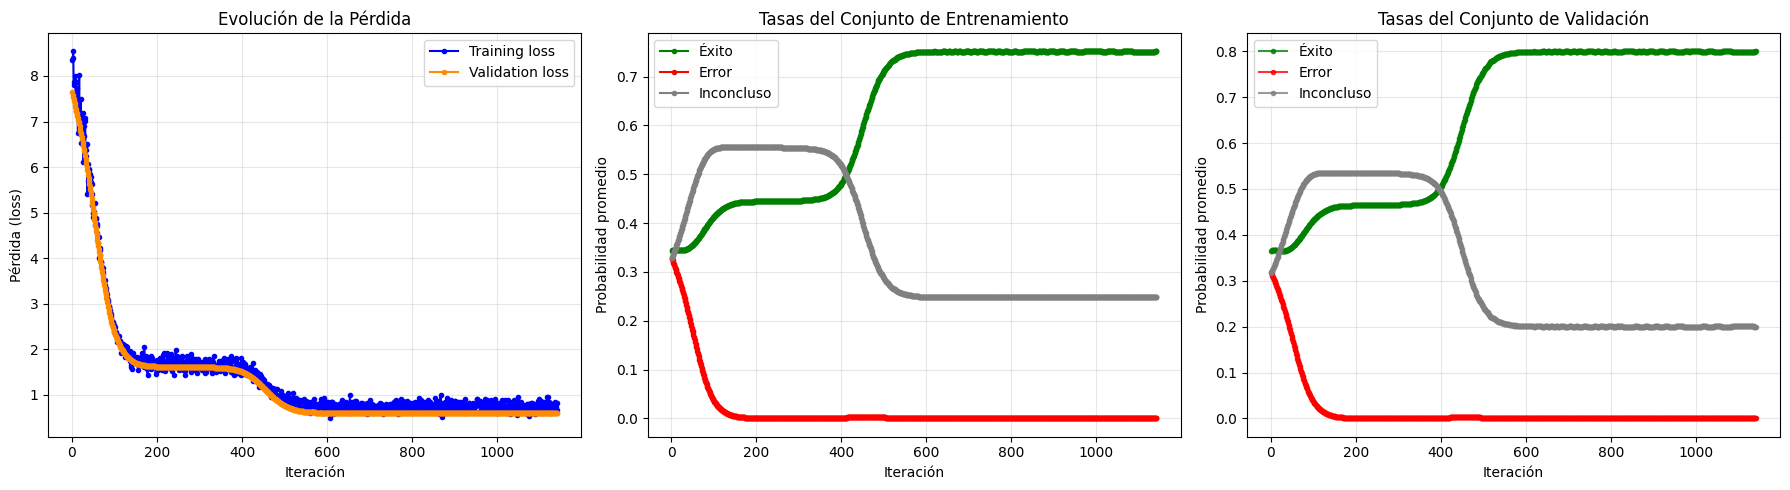

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

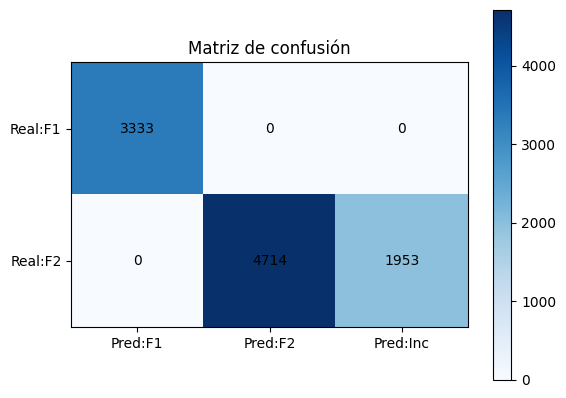

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
